# Методы и алгоритмы анализа влияния различных факторов на рынок недвижимости

**Описание проекта**

> С появлением в России рыночных отношений возникла объективная необходимость независимой оценки рыночной стоимости недвижимости. Проблемы оценки недвижимости давно решаются зарубежными и сравнительно недавно - российскими учеными-экономистами.

> Существующие методики оценки объектов недвижимости основаны на категориях, отражающих развитые рыночные отношения, и практически «не работают» в условиях почти полного отсутствия рыночной информации, что порождает множество конфликтов между субъектами рыночных отношений. Об этом свидетельствует судебная практика оспаривания результатов проводимых оценок. 

> В связи с этим, для осуществления оценочной деятельности необходимо формирование новых подходов и методов оценки недвижимости, что будет способствовать справедливому формированию цен на недвижимость, информационной открытости локальных рынков недвижимости и, следовательно, тем самым улучшению инвестиционного климата в регионах.


Датасет загружен из платформы Kaggle. 

Ссылка: https://www.kaggle.com/datasets/mrdaniilak/russia-real-estate-2021

Описание данных:
- дата загрузки объявления
- цена на недвижимость
- этаж
- количество этажей в доме
- количество комнат
- площадь недвидимости
- площадь кухни
- широта
- долгота
- тип здания 
  - 0 - Не известно;
  - 1 - Другое;
  - 2 - Панельное;
  - 3 - Монолитное;
  - 4 - Кирпичное;
  - 5 - Блочное;
  - 6 - Деревенное.
- тип недвижимости
  - 0 - Вторичный рынок недвижимости; 
  - 2 - Новое здание.
- почтовый индекс
- идентификатор улицы
- номер региона
- идентификатор дома


## Предобработка данных

### Импортируем необходимые библиотеки и взглянем на данные

In [181]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_percentage_error, mean_absolute_error
from sklearn import tree
from geopy.distance import geodesic

from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor

import catboost
from catboost import CatBoostRegressor, cv, Pool

#import lightgbm as lgb
#from lightgbm import LGBMRegressor

import time

import math 

import warnings
warnings.simplefilter('ignore')

In [2]:
data = pd.read_csv('input_data.csv', sep=';')

In [3]:
data.head()

date     price  level  levels  rooms  area  kitchen_area    geo_lat  \
0  2021-01-01   2451300     15      31      1  30.3           0.0  56.780112   
1  2021-01-01   1450000      5       5      1  33.0           6.0  44.608154   
2  2021-01-01  10700000      4      13      3  85.0          12.0  55.540060   
3  2021-01-01   3100000      3       5      3  82.0           9.0  44.608154   
4  2021-01-01   2500000      2       3      1  30.0           9.0  44.738685   

     geo_lon  building_type  object_type  postal_code  street_id  id_region  \
0  60.699355              0            2     620000.0        NaN         66   
1  40.138381              0            0     385000.0        NaN          1   
2  37.725112              3            0     142701.0   242543.0         50   
3  40.138381              0            0     385000.0        NaN          1   
4  37.713668              3            2     353960.0   439378.0         23   

    house_id  
0  1632918.0  
1        NaN  
2   681306.0  
3        NaN  
4  1730985.0

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11358150 entries, 0 to 11358149
Data columns (total 15 columns):
 #   Column         Dtype  
---  ------         -----  
 0   date           object 
 1   price          int64  
 2   level          int64  
 3   levels         int64  
 4   rooms          int64  
 5   area           float64
 6   kitchen_area   float64
 7   geo_lat        float64
 8   geo_lon        float64
 9   building_type  int64  
 10  object_type    int64  
 11  postal_code    float64
 12  street_id      float64
 13  id_region      int64  
 14  house_id       float64
dtypes: float64(7), int64(7), object(1)
memory usage: 1.3+ GB


Приведем названия столбцов к удобному виду:

In [5]:
data.columns

Index(['date', 'price', 'level', 'levels', 'rooms', 'area', 'kitchen_area',
       'geo_lat', 'geo_lon', 'building_type', 'object_type', 'postal_code',
       'street_id', 'id_region', 'house_id'],
      dtype='object')

In [6]:
data.columns = ['date', 'price', 'level', 'levels', 'rooms', 'area', 'kitchen_area',
       'latitude', 'longitude', 'building_type', 'object_type', 'postal_code',
       'street_id', 'region', 'house_id']

In [7]:
data['region'].value_counts()

77    1032600
72     865423
23     846948
78     765872
50     754267
       ...   
8        2498
6        1195
87        147
79         55
83         48
Name: region, Length: 86, dtype: int64

Исследовать будем город Белгород, поэтому сделаем срез с данными белгорода:

Отфильтруем сначала по региону, а потом по почтовым индексам:

In [8]:
data_bgd = data[data['region'] == 31]
data_bgd

date    price  level  levels  rooms   area  kitchen_area  \
75        2021-01-01  3880000      1       9      2   60.0           9.5   
292       2021-01-01  3500000      1       4      2   57.7          10.0   
367       2021-01-01  3950000      1       9      2   51.0           9.0   
420       2021-01-01  3700000      4       4      3  104.0           0.0   
1148      2021-01-01  3400000      1       5      3   57.0           9.0   
...              ...      ...    ...     ...    ...    ...           ...   
11355945  2021-12-31  4800000      3       9      4   82.1          11.0   
11356042  2021-12-31  3370000      4       5      1   32.0           6.0   
11357073  2021-12-31  9000000      7       9      3  104.0          13.0   
11357641  2021-12-31  6700000      1      12      3   94.6          13.4   
11358015  2021-12-31  3750000      4       5      1   44.0           9.7   

           latitude  longitude  building_type  object_type  postal_code  \
75        50.569676  36.576500              0            0     308033.0   
292       50.582151  36.660419              4            0     308013.0   
367       50.555684  36.575505              2            0     308004.0   
420       51.301583  37.897593              4            0     309511.0   
1148      50.612312  36.576919              4            0     308002.0   
...             ...        ...            ...          ...          ...   
11355945  51.310764  37.895455              0            0     309512.0   
11356042  50.631864  36.583110              0            0     308023.0   
11357073  50.567401  36.589064              0            0     308033.0   
11357641  51.314745  37.914978              0            0     309503.0   
11358015  50.585252  36.672988              0            0     308029.0   

          street_id  region   house_id  
75         473680.0      31  2138731.0  
292        235193.0      31  2456500.0  
367        142358.0      31  2484431.0  
420        301193.0      31  2005381.0  
1148       549537.0      31  2818216.0  
...             ...     ...        ...  
11355945   224650.0      31  2228997.0  
11356042   497145.0      31  1159076.0  
11357073   158492.0      31  1757293.0  
11357641   157085.0      31  2663987.0  
11358015   216591.0      31  2664851.0  

[107018 rows x 15 columns]

In [9]:
data_bgd = data_bgd[(data_bgd['postal_code'] < 308511) & (data_bgd['postal_code'] > 308000)]
data_bgd

date    price  level  levels  rooms   area  kitchen_area  \
75        2021-01-01  3880000      1       9      2   60.0           9.5   
292       2021-01-01  3500000      1       4      2   57.7          10.0   
367       2021-01-01  3950000      1       9      2   51.0           9.0   
1148      2021-01-01  3400000      1       5      3   57.0           9.0   
1777      2021-01-01  5007000      9      16      3  114.0          17.2   
...              ...      ...    ...     ...    ...    ...           ...   
11352932  2021-12-31  5500000      8      10      2   51.7           9.0   
11354561  2021-12-31  4200000      6      12      1   39.6           8.3   
11356042  2021-12-31  3370000      4       5      1   32.0           6.0   
11357073  2021-12-31  9000000      7       9      3  104.0          13.0   
11358015  2021-12-31  3750000      4       5      1   44.0           9.7   

           latitude  longitude  building_type  object_type  postal_code  \
75        50.569676  36.576500              0            0     308033.0   
292       50.582151  36.660419              4            0     308013.0   
367       50.555684  36.575505              2            0     308004.0   
1148      50.612312  36.576919              4            0     308002.0   
1777      50.572646  36.561332              5            2     308019.0   
...             ...        ...            ...          ...          ...   
11352932  50.564194  36.569256              0            0     308004.0   
11354561  50.584459  36.646547              0            0     308013.0   
11356042  50.631864  36.583110              0            0     308023.0   
11357073  50.567401  36.589064              0            0     308033.0   
11358015  50.585252  36.672988              0            0     308029.0   

          street_id  region   house_id  
75         473680.0      31  2138731.0  
292        235193.0      31  2456500.0  
367        142358.0      31  2484431.0  
1148       549537.0      31  2818216.0  
1777            NaN      31        NaN  
...             ...     ...        ...  
11352932        NaN      31        NaN  
11354561   496646.0      31   639367.0  
11356042   497145.0      31  1159076.0  
11357073   158492.0      31  1757293.0  
11358015   216591.0      31  2664851.0  

[63020 rows x 15 columns]

In [10]:
data_bgd['region'].value_counts()

31    63020
Name: region, dtype: int64

Расставим точки с объявлениями на карте чтобы убедиться в географии:

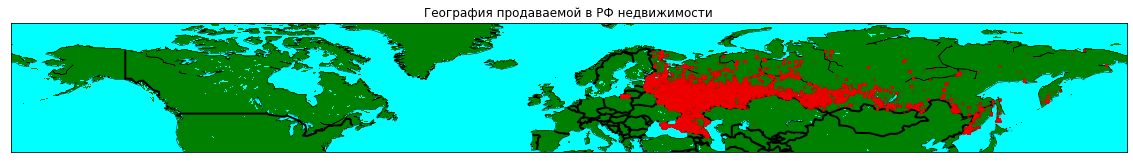

In [13]:
lat = data['latitude'].values
lon = data['longitude'].values

plt.figure(figsize=(20, 15))

m = Basemap(projection="mill"
            ,llcrnrlat=lat.min()-5
            ,urcrnrlat=lat.max()+5
            ,llcrnrlon=lon.min()-5
            ,urcrnrlon=lon.max()+5
            ,resolution='c'
            ,epsg=4269)
m.drawlsmask(land_color='green',ocean_color='aqua',lakes=True)
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=2) 


parallels = np.arange(0.,81,10.)
meridians = np.arange(0.,360.,10.)

# Pickup coordinates
m.plot(lon, lat, 'ro', markersize=2 ,alpha=.05)

plt.title("География продаваемой в РФ недвижимости")
plt.show()

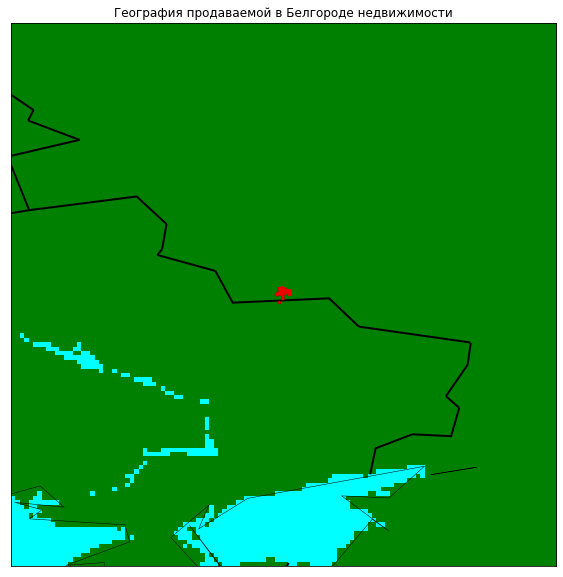

In [14]:
# read in data to use for plotted points
lat = data_bgd['latitude'].values
lon = data_bgd['longitude'].values

# Prepare basemap

plt.figure(figsize=(10,10))

m = Basemap(projection="mill"
            ,llcrnrlat=lat.min()-5
            ,urcrnrlat=lat.max()+5
            ,llcrnrlon=lon.min()-5
            ,urcrnrlon=lon.max()+5
            ,resolution='c'
            ,epsg=4269)
m.drawlsmask(land_color='green',ocean_color='aqua',lakes=True)
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=2) 


parallels = np.arange(0.,81,10.)
meridians = np.arange(0.,360.,10.)

# Pickup coordinates
m.plot(lon, lat, 'ro', markersize=2 ,alpha=.05)

plt.title("География продаваемой в Белгороде недвижимости")
plt.show()

Проверим данные на наличие пропусков:

In [11]:
data_bgd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63020 entries, 75 to 11358015
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           63020 non-null  object 
 1   price          63020 non-null  int64  
 2   level          63020 non-null  int64  
 3   levels         63020 non-null  int64  
 4   rooms          63020 non-null  int64  
 5   area           63020 non-null  float64
 6   kitchen_area   63020 non-null  float64
 7   latitude       63020 non-null  float64
 8   longitude      63020 non-null  float64
 9   building_type  63020 non-null  int64  
 10  object_type    63020 non-null  int64  
 11  postal_code    63020 non-null  float64
 12  street_id      39594 non-null  float64
 13  region         63020 non-null  int64  
 14  house_id       40067 non-null  float64
dtypes: float64(7), int64(7), object(1)
memory usage: 7.7+ MB


В целом, данные которые содержат полезную для исседования информацию - чистые. Пропуски присутствуют только в столбцах: street_id, house_id. 

Проверим данные на наличие дубликатов:

In [12]:
data_bgd.duplicated().sum()

1334

In [13]:
data_bgd.drop_duplicates(inplace=True)

In [14]:
data_bgd.duplicated().sum()

0

Для удобства анализа преобразуем тип недвижимости и дома к удобному формату.

- тип здания 
  - 0 - Не известно;
  - 1 - Другое;
  - 2 - Панельное;
  - 3 - Монолитное;
  - 4 - Кирпичное;
  - 5 - Блочное;
  - 6 - Деревенное.
- тип недвижимости
  - 0 - Вторичный рынок недвижимости; 
  - 2 - Новое здание.

In [15]:
def change_type(row):
  if row['building_type'] == 0:
    row['building_type'] = 'Не известно'
  if row['building_type'] == 1:
    row['building_type'] = 'другое'
  if row['building_type'] == 2:
    row['building_type'] = 'панельный'
  if row['building_type'] == 3:
    row['building_type'] = 'монолитный'
  if row['building_type'] == 4:
    row['building_type'] = 'кирпичный'
  if row['building_type'] == 5:
    row['building_type'] = 'блочный'  
  if row['building_type'] == 6:
    row['building_type'] = 'деревянный'  

  if row['object_type'] == 0:
    row['object_type'] = 'новостройка'
  if row['object_type'] == 2:
    row['object_type'] = 'вторичное'

  return row

In [16]:
data_bgd = data_bgd.apply(change_type, axis=1)
data_bgd.head()

date    price  level  levels  rooms   area  kitchen_area  \
75    2021-01-01  3880000      1       9      2   60.0           9.5   
292   2021-01-01  3500000      1       4      2   57.7          10.0   
367   2021-01-01  3950000      1       9      2   51.0           9.0   
1148  2021-01-01  3400000      1       5      3   57.0           9.0   
1777  2021-01-01  5007000      9      16      3  114.0          17.2   

       latitude  longitude building_type  object_type  postal_code  street_id  \
75    50.569676  36.576500   Не известно  новостройка     308033.0   473680.0   
292   50.582151  36.660419     кирпичный  новостройка     308013.0   235193.0   
367   50.555684  36.575505     панельный  новостройка     308004.0   142358.0   
1148  50.612312  36.576919     кирпичный  новостройка     308002.0   549537.0   
1777  50.572646  36.561332       блочный    вторичное     308019.0        NaN   

      region   house_id  
75        31  2138731.0  
292       31  2456500.0  
367       31  2484431.0  
1148      31  2818216.0  
1777      31        NaN

Преобразуем теперь столбец с датой к типу datetime:

In [17]:
data_bgd['date'] = pd.to_datetime(data_bgd['date'])
data_bgd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61686 entries, 75 to 11358015
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           61686 non-null  datetime64[ns]
 1   price          61686 non-null  int64         
 2   level          61686 non-null  int64         
 3   levels         61686 non-null  int64         
 4   rooms          61686 non-null  int64         
 5   area           61686 non-null  float64       
 6   kitchen_area   61686 non-null  float64       
 7   latitude       61686 non-null  float64       
 8   longitude      61686 non-null  float64       
 9   building_type  61686 non-null  object        
 10  object_type    61686 non-null  object        
 11  postal_code    61686 non-null  float64       
 12  street_id      38639 non-null  float64       
 13  region         61686 non-null  int64         
 14  house_id       39111 non-null  float64       
dtypes: datetime64[n

### Проверим данные на их адекватность:

In [18]:
data_bgd.describe()

price         level        levels         rooms          area  \
count  6.168600e+04  61686.000000  61686.000000  61686.000000  61686.000000   
mean   4.517661e+06      4.921943      8.604724      2.009305     55.154680   
std    3.986335e+07      3.325943      3.793582      0.986302     22.964643   
min    0.000000e+00      0.000000      0.000000     -1.000000     10.000000   
25%    3.250000e+06      2.000000      5.000000      1.000000     39.000000   
50%    3.990000e+06      4.000000      9.000000      2.000000     50.000000   
75%    4.950000e+06      7.000000     10.000000      3.000000     65.000000   
max    8.999999e+09     19.000000     25.000000      8.000000    375.000000   

       kitchen_area      latitude     longitude    postal_code      street_id  \
count  61686.000000  61686.000000  61686.000000   61686.000000   38639.000000   
mean      -3.156199     50.580924     36.581567  308062.206741  341525.992003   
std       35.104332      0.027059      0.034789     139.518903  143015.729768   
min     -100.000000     50.369235     36.434085  308001.000000  119015.000000   
25%        6.000000     50.561735     36.565834  308009.000000  211710.000000   
50%        8.600000     50.578893     36.576659  308023.000000  335161.000000   
75%       10.000000     50.599632     36.589424  308031.000000  468249.000000   
max       96.000000     50.655608     36.761990  308510.000000  586672.000000   

        region      house_id  
count  61686.0  3.911100e+04  
mean      31.0  1.723266e+06  
std        0.0  6.298073e+05  
min       31.0  5.901680e+05  
25%       31.0  1.215513e+06  
50%       31.0  1.745319e+06  
75%       31.0  2.251688e+06  
max       31.0  2.837955e+06

Из числового описания данных видно что есть объявления с отрицательной площадью кухни, отрицательным числом комнат. Также есть данные с аномально высокой ценой. Это необходимо проверить:

In [22]:
data_bgd[data_bgd['rooms'] < 0]

date    price  level  levels  rooms  area  kitchen_area  \
19560    2021-01-03  6850000      7      13     -1  51.4           9.0   
21065    2021-01-03  3200000      4       4     -1  32.0           6.0   
76435    2021-01-08  3200000      4       4     -1  33.0           7.0   
110494   2021-01-11  2450000      2       5     -1  27.0          11.0   
112567   2021-01-11  5400000     12      16     -1  45.0           9.0   
...             ...      ...    ...     ...    ...   ...           ...   
11276944 2021-12-26  3600000      5       5     -1  30.0           7.0   
11284278 2021-12-27  3300000      2       5     -1  26.0        -100.0   
11301115 2021-12-27  2400000      5       5     -1  20.0           3.0   
11304613 2021-12-28  3950000      8      14     -1  27.8           8.0   
11343817 2021-12-30  3900000      2      15     -1  26.0           5.0   

           latitude  longitude building_type  object_type  postal_code  \
19560     50.589577  36.587523   Не известно  новостройка     308009.0   
21065     50.601341  36.582249     кирпичный  новостройка     308009.0   
76435     50.601341  36.582249     кирпичный  новостройка     308009.0   
110494    50.597647  36.585665   Не известно  новостройка     308015.0   
112567    50.599947  36.603203   Не известно  новостройка     308001.0   
...             ...        ...           ...          ...          ...   
11276944  50.598382  36.533710   Не известно  новостройка     308015.0   
11284278  50.598778  36.534093   Не известно  новостройка     308015.0   
11301115  50.565003  36.534440   Не известно  новостройка     308008.0   
11304613  50.604716  36.589225   Не известно  новостройка     308009.0   
11343817  50.604716  36.589225   Не известно  новостройка     308009.0   

          street_id  region   house_id  
19560           NaN      31        NaN  
21065      335161.0      31  1336231.0  
76435      335161.0      31  1336231.0  
110494     356140.0      31  1650682.0  
112567     211710.0      31  2023312.0  
...             ...     ...        ...  
11276944        NaN      31        NaN  
11284278        NaN      31        NaN  
11301115   352668.0      31  2116585.0  
11304613   204952.0      31  1776815.0  
11343817   204952.0      31  1776815.0  

[631 rows x 15 columns]

In [20]:
data_bgd[data_bgd['rooms'] < 0]['rooms'].value_counts()

-1    631
Name: rooms, dtype: int64

In [21]:
data_bgd[data_bgd['rooms'] < 0].describe()

price       level      levels  rooms        area  kitchen_area  \
count  6.310000e+02  631.000000  631.000000  631.0  631.000000    631.000000   
mean   3.906917e+06    5.213946    9.438986   -1.0   40.412694    -19.059033   
std    2.227555e+06    3.455412    4.648161    0.0   25.991982     46.340257   
min    0.000000e+00    1.000000    1.000000   -1.0   12.000000   -100.000000   
25%    2.750000e+06    3.000000    5.000000   -1.0   27.000000      0.000000   
50%    3.600000e+06    5.000000    9.000000   -1.0   34.000000      5.000000   
75%    4.500000e+06    7.000000   14.000000   -1.0   47.000000      9.000000   
max    1.760000e+07   19.000000   22.000000   -1.0  261.100000     39.000000   

         latitude   longitude    postal_code      street_id  region  \
count  631.000000  631.000000     631.000000     407.000000   631.0   
mean    50.590583   36.572562  308049.652932  368201.449631    31.0   
std      0.020889    0.029545     126.536456  121939.726515     0.0   
min     50.524140   36.464710  308001.000000  131946.000000    31.0   
25%     50.580411   36.559760  308009.000000  281771.000000    31.0   
50%     50.597768   36.575987  308015.000000  356140.000000    31.0   
75%     50.603374   36.587423  308019.000000  468249.000000    31.0   
max     50.638290   36.689642  308510.000000  586672.000000    31.0   

           house_id  
count  4.080000e+02  
mean   1.762977e+06  
std    6.058708e+05  
min    6.471920e+05  
25%    1.218703e+06  
50%    1.780039e+06  
75%    2.261815e+06  
max    2.813101e+06

Исходя из числового описания можно сделать вывод что данные нормальные и при их выгрузке произошла ошибка. Но поскольку таких строк мало, то лучше удалим их:

In [24]:
data_bgd = data_bgd[data_bgd['rooms']>=0]
data_bgd[data_bgd['rooms'] < 0]['rooms'].count()

0

Теперь проверим площади кухонь:

In [25]:
data_bgd[data_bgd['kitchen_area'] <= 0].head()

date     price  level  levels  rooms   area  kitchen_area  \
3180  2021-01-01   4800000     12      15      3   86.6        -100.0   
11509 2021-01-02  13750000     14      16      3  250.0        -100.0   
12789 2021-01-02   2900000      4       5      1   30.5        -100.0   
20630 2021-01-03   3850000      9      12      2   52.0           0.0   
20903 2021-01-03   5200000      1       2      5  187.0           0.0   

        latitude  longitude building_type  object_type  postal_code  \
3180   50.556562  36.566085     кирпичный  новостройка     308036.0   
11509  50.610266  36.585398    монолитный  новостройка     308014.0   
12789  50.601651  36.579722     кирпичный  новостройка     308009.0   
20630  50.579366  36.581682     кирпичный  новостройка     308024.0   
20903  50.518359  36.550679   Не известно  новостройка     308504.0   

       street_id  region   house_id  
3180         NaN      31        NaN  
11509   497145.0      31   790765.0  
12789   335161.0      31   900143.0  
20630   316154.0      31  1578677.0  
20903        NaN      31        NaN

In [26]:
data_bgd[data_bgd['kitchen_area'] < 0]['kitchen_area'].value_counts()

-100.0    6905
Name: kitchen_area, dtype: int64

В этом случае ситуация сложнее. Данные составляют 10% от всей выборки и они явно ошибочные. Мы можем либо удалить эти данные и потерять часть информации либо заменить эти данные на что-то определенное. Поскольку перед нами стоит задача регрессии, а этот признак числовой, то лучше избавиться от этих строк вообще.

In [27]:
data_bgd = data_bgd[data_bgd['kitchen_area'] > 0]
data_bgd.shape

(52936, 15)

Проверим цены в объявлениях на аномалии:

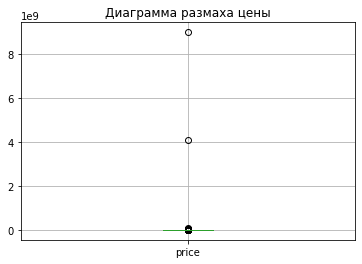

In [28]:
data_bgd.boxplot('price')
plt.title('Диаграмма размаха цены')
plt.show()

Из диаграммы размаха видно что есть аномально большие цены. Найдем эти объявления:

In [29]:
data_bgd[data_bgd['price'] > 100000000]

date       price  level  levels  rooms  area  kitchen_area  \
6947635 2021-08-17  4100000000      8       9      2  44.7           6.3   
7182829 2021-08-24  8999999488     10      10      3  83.6          10.9   

          latitude  longitude building_type  object_type  postal_code  \
6947635  50.570553  36.584736   Не известно  новостройка     308033.0   
7182829  50.595737  36.587290   Не известно  новостройка     308009.0   

         street_id  region  house_id  
6947635        NaN      31       NaN  
7182829   267556.0      31  768483.0

Сразу видно что это плохие данные и их необходимо удалить:

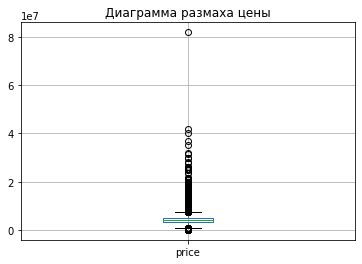

In [30]:
data_bgd = data_bgd[data_bgd['price'] < 100000000]
data_bgd.boxplot('price')
plt.title('Диаграмма размаха цены')
plt.show()

In [31]:
data_bgd[data_bgd['price'] > 80000000]

date     price  level  levels  rooms  area  kitchen_area  \
9116446 2021-10-20  82000000      3       9      2  66.0          10.0   

          latitude  longitude building_type  object_type  postal_code  \
9116446  50.606399  36.582213   Не известно  новостройка     308002.0   

         street_id  region   house_id  
9116446   320307.0      31  1307129.0

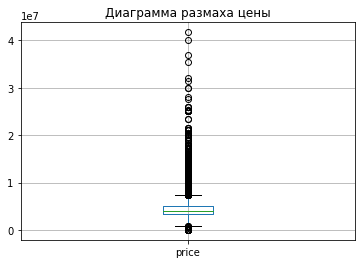

In [32]:
data_bgd = data_bgd[data_bgd['price'] < 80000000]
data_bgd.boxplot('price')
plt.title('Диаграмма размаха цены')
plt.show()

### Удалим ненужные переменные

In [34]:
del data

## Feature Engineering

Также для анализа и моделирования будет хорошо, если мы добавим дополнительные признаки. Например, цена за квадратный метр, отношение площади кухни к общей площади недвижимости, расстояние до центра города, месяц продажи, день недели.

### Цена за квадратный метр

In [35]:
data_bgd.head()

date    price  level  levels  rooms   area  kitchen_area  \
75   2021-01-01  3880000      1       9      2   60.0           9.5   
292  2021-01-01  3500000      1       4      2   57.7          10.0   
367  2021-01-01  3950000      1       9      2   51.0           9.0   
1148 2021-01-01  3400000      1       5      3   57.0           9.0   
1777 2021-01-01  5007000      9      16      3  114.0          17.2   

       latitude  longitude building_type  object_type  postal_code  street_id  \
75    50.569676  36.576500   Не известно  новостройка     308033.0   473680.0   
292   50.582151  36.660419     кирпичный  новостройка     308013.0   235193.0   
367   50.555684  36.575505     панельный  новостройка     308004.0   142358.0   
1148  50.612312  36.576919     кирпичный  новостройка     308002.0   549537.0   
1777  50.572646  36.561332       блочный    вторичное     308019.0        NaN   

      region   house_id  
75        31  2138731.0  
292       31  2456500.0  
367       31  2484431.0  
1148      31  2818216.0  
1777      31        NaN

In [36]:
data_bgd['price_per_meter'] = data_bgd['price'] / data_bgd['area']
data_bgd.head()

date    price  level  levels  rooms   area  kitchen_area  \
75   2021-01-01  3880000      1       9      2   60.0           9.5   
292  2021-01-01  3500000      1       4      2   57.7          10.0   
367  2021-01-01  3950000      1       9      2   51.0           9.0   
1148 2021-01-01  3400000      1       5      3   57.0           9.0   
1777 2021-01-01  5007000      9      16      3  114.0          17.2   

       latitude  longitude building_type  object_type  postal_code  street_id  \
75    50.569676  36.576500   Не известно  новостройка     308033.0   473680.0   
292   50.582151  36.660419     кирпичный  новостройка     308013.0   235193.0   
367   50.555684  36.575505     панельный  новостройка     308004.0   142358.0   
1148  50.612312  36.576919     кирпичный  новостройка     308002.0   549537.0   
1777  50.572646  36.561332       блочный    вторичное     308019.0        NaN   

      region   house_id  price_per_meter  
75        31  2138731.0     64666.666667  
292       31  2456500.0     60658.578856  
367       31  2484431.0     77450.980392  
1148      31  2818216.0     59649.122807  
1777      31        NaN     43921.052632

Цена за квадратный метр будет для нас целевым признаком, поэтому округлим ее для удобства:

In [37]:
data_bgd['price_per_meter'] = data_bgd['price_per_meter'].round(0)
data_bgd.head()

date    price  level  levels  rooms   area  kitchen_area  \
75   2021-01-01  3880000      1       9      2   60.0           9.5   
292  2021-01-01  3500000      1       4      2   57.7          10.0   
367  2021-01-01  3950000      1       9      2   51.0           9.0   
1148 2021-01-01  3400000      1       5      3   57.0           9.0   
1777 2021-01-01  5007000      9      16      3  114.0          17.2   

       latitude  longitude building_type  object_type  postal_code  street_id  \
75    50.569676  36.576500   Не известно  новостройка     308033.0   473680.0   
292   50.582151  36.660419     кирпичный  новостройка     308013.0   235193.0   
367   50.555684  36.575505     панельный  новостройка     308004.0   142358.0   
1148  50.612312  36.576919     кирпичный  новостройка     308002.0   549537.0   
1777  50.572646  36.561332       блочный    вторичное     308019.0        NaN   

      region   house_id  price_per_meter  
75        31  2138731.0          64667.0  
292       31  2456500.0          60659.0  
367       31  2484431.0          77451.0  
1148      31  2818216.0          59649.0  
1777      31        NaN          43921.0

### Отношение площади кухни к общей

In [38]:
data_bgd['ratio_kitchen_total_area'] = data_bgd['kitchen_area'] / data_bgd['area']
data_bgd.head()

date    price  level  levels  rooms   area  kitchen_area  \
75   2021-01-01  3880000      1       9      2   60.0           9.5   
292  2021-01-01  3500000      1       4      2   57.7          10.0   
367  2021-01-01  3950000      1       9      2   51.0           9.0   
1148 2021-01-01  3400000      1       5      3   57.0           9.0   
1777 2021-01-01  5007000      9      16      3  114.0          17.2   

       latitude  longitude building_type  object_type  postal_code  street_id  \
75    50.569676  36.576500   Не известно  новостройка     308033.0   473680.0   
292   50.582151  36.660419     кирпичный  новостройка     308013.0   235193.0   
367   50.555684  36.575505     панельный  новостройка     308004.0   142358.0   
1148  50.612312  36.576919     кирпичный  новостройка     308002.0   549537.0   
1777  50.572646  36.561332       блочный    вторичное     308019.0        NaN   

      region   house_id  price_per_meter  ratio_kitchen_total_area  
75        31  2138731.0          64667.0                  0.158333  
292       31  2456500.0          60659.0                  0.173310  
367       31  2484431.0          77451.0                  0.176471  
1148      31  2818216.0          59649.0                  0.157895  
1777      31        NaN          43921.0                  0.150877

### Расстояние до центра

Определим центр города. В Белгороде это соборная площадь. Найдем широту и долготу этого объекта, а далее будем искать расстояния от объектов недвижимости до центра.

In [42]:
def calculate_distance(row):
  latitude_center_bgd = 50.595511 
  longitute_center_bgd = 36.587313
  center = (longitute_center_bgd, latitude_center_bgd)
  buf = (row['longitude'], row['latitude'])
  distance = geodesic(center, buf).km

  return distance

In [44]:
latitude_center_bgd = 50.595511 
longitute_center_bgd = 36.587313
city_center_coordinates = [latitude_center_bgd, longitute_center_bgd]
def get_azimuth(latitude, longitude):
 
    rad = 6372795

    llat1 = city_center_coordinates[0]
    llong1 = city_center_coordinates[1]
    llat2 = latitude
    llong2 = longitude

    lat1 = llat1*math.pi/180.
    lat2 = llat2*math.pi/180.
    long1 = llong1*math.pi/180.
    long2 = llong2*math.pi/180.

    cl1 = math.cos(lat1)
    cl2 = math.cos(lat2)
    sl1 = math.sin(lat1)
    sl2 = math.sin(lat2)
    delta = long2 - long1
    cdelta = math.cos(delta)
    sdelta = math.sin(delta)

    y = math.sqrt(math.pow(cl2*sdelta,2)+math.pow(cl1*sl2-sl1*cl2*cdelta,2))
    x = sl1*sl2+cl1*cl2*cdelta
    ad = math.atan2(y,x)

    x = (cl1*sl2) - (sl1*cl2*cdelta)
    y = sdelta*cl2
    z = math.degrees(math.atan(-y/x))

    if (x < 0):
        z = z+180.

    z2 = (z+180.) % 360. - 180.
    z2 = - math.radians(z2)
    anglerad2 = z2 - ((2*math.pi)*math.floor((z2/(2*math.pi))) )
    angledeg = (anglerad2*180.)/math.pi
    
    return round(angledeg, 2)

In [47]:
data_bgd['azimuth'] = list(map(lambda x, y: get_azimuth(x, y), data_bgd['latitude'], data_bgd['longitude']))

In [48]:
data_bgd['distance_to_center'] = data_bgd.apply(calculate_distance, axis=1)
data_bgd.head()

date    price  level  levels  rooms   area  kitchen_area  \
75   2021-01-01  3880000      1       9      2   60.0           9.5   
292  2021-01-01  3500000      1       4      2   57.7          10.0   
367  2021-01-01  3950000      1       9      2   51.0           9.0   
1148 2021-01-01  3400000      1       5      3   57.0           9.0   
1777 2021-01-01  5007000      9      16      3  114.0          17.2   

       latitude  longitude building_type  object_type  postal_code  street_id  \
75    50.569676  36.576500   Не известно  новостройка     308033.0   473680.0   
292   50.582151  36.660419     кирпичный  новостройка     308013.0   235193.0   
367   50.555684  36.575505     панельный  новостройка     308004.0   142358.0   
1148  50.612312  36.576919     кирпичный  новостройка     308002.0   549537.0   
1777  50.572646  36.561332       блочный    вторичное     308019.0        NaN   

      region   house_id  price_per_meter  ratio_kitchen_total_area  azimuth  \
75        31  2138731.0          64667.0                  0.158333   194.89   
292       31  2456500.0          60659.0                  0.173310   106.03   
367       31  2484431.0          77451.0                  0.176471   190.67   
1148      31  2818216.0          59649.0                  0.157895   338.57   
1777      31        NaN          43921.0                  0.150877   215.82   

      distance_to_center  
75              2.604918  
292             8.200197  
367             3.797638  
1148            1.895039  
1777            3.535620

Округлим расстояние до сотен метров для моделирования:

In [49]:
data_bgd['distance_to_center'] = data_bgd['distance_to_center'].round(1)
data_bgd['distance_to_center'].head()

75      2.6
292     8.2
367     3.8
1148    1.9
1777    3.5
Name: distance_to_center, dtype: float64

### Месяц продажи и день недели

In [50]:
data_bgd['month_of_sale'] = data_bgd['date'].dt.month
data_bgd.head()

date    price  level  levels  rooms   area  kitchen_area  \
75   2021-01-01  3880000      1       9      2   60.0           9.5   
292  2021-01-01  3500000      1       4      2   57.7          10.0   
367  2021-01-01  3950000      1       9      2   51.0           9.0   
1148 2021-01-01  3400000      1       5      3   57.0           9.0   
1777 2021-01-01  5007000      9      16      3  114.0          17.2   

       latitude  longitude building_type  object_type  postal_code  street_id  \
75    50.569676  36.576500   Не известно  новостройка     308033.0   473680.0   
292   50.582151  36.660419     кирпичный  новостройка     308013.0   235193.0   
367   50.555684  36.575505     панельный  новостройка     308004.0   142358.0   
1148  50.612312  36.576919     кирпичный  новостройка     308002.0   549537.0   
1777  50.572646  36.561332       блочный    вторичное     308019.0        NaN   

      region   house_id  price_per_meter  ratio_kitchen_total_area  azimuth  \
75        31  2138731.0          64667.0                  0.158333   194.89   
292       31  2456500.0          60659.0                  0.173310   106.03   
367       31  2484431.0          77451.0                  0.176471   190.67   
1148      31  2818216.0          59649.0                  0.157895   338.57   
1777      31        NaN          43921.0                  0.150877   215.82   

      distance_to_center  month_of_sale  
75                   2.6              1  
292                  8.2              1  
367                  3.8              1  
1148                 1.9              1  
1777                 3.5              1

In [51]:
data_bgd['day_of_week'] = data_bgd['date'].dt.day_of_week
data_bgd.head()

date    price  level  levels  rooms   area  kitchen_area  \
75   2021-01-01  3880000      1       9      2   60.0           9.5   
292  2021-01-01  3500000      1       4      2   57.7          10.0   
367  2021-01-01  3950000      1       9      2   51.0           9.0   
1148 2021-01-01  3400000      1       5      3   57.0           9.0   
1777 2021-01-01  5007000      9      16      3  114.0          17.2   

       latitude  longitude building_type  ... postal_code  street_id  region  \
75    50.569676  36.576500   Не известно  ...    308033.0   473680.0      31   
292   50.582151  36.660419     кирпичный  ...    308013.0   235193.0      31   
367   50.555684  36.575505     панельный  ...    308004.0   142358.0      31   
1148  50.612312  36.576919     кирпичный  ...    308002.0   549537.0      31   
1777  50.572646  36.561332       блочный  ...    308019.0        NaN      31   

       house_id  price_per_meter  ratio_kitchen_total_area  azimuth  \
75    2138731.0          64667.0                  0.158333   194.89   
292   2456500.0          60659.0                  0.173310   106.03   
367   2484431.0          77451.0                  0.176471   190.67   
1148  2818216.0          59649.0                  0.157895   338.57   
1777        NaN          43921.0                  0.150877   215.82   

      distance_to_center  month_of_sale  day_of_week  
75                   2.6              1            4  
292                  8.2              1            4  
367                  3.8              1            4  
1148                 1.9              1            4  
1777                 3.5              1            4  

[5 rows x 21 columns]

## Исследовательский анализ данных

### Изучим следующие параметры: площадь, цена, число комнат. Построим гистограммы для каждого параметра

In [52]:
data_bgd.head()

date    price  level  levels  rooms   area  kitchen_area  \
75   2021-01-01  3880000      1       9      2   60.0           9.5   
292  2021-01-01  3500000      1       4      2   57.7          10.0   
367  2021-01-01  3950000      1       9      2   51.0           9.0   
1148 2021-01-01  3400000      1       5      3   57.0           9.0   
1777 2021-01-01  5007000      9      16      3  114.0          17.2   

       latitude  longitude building_type  ... postal_code  street_id  region  \
75    50.569676  36.576500   Не известно  ...    308033.0   473680.0      31   
292   50.582151  36.660419     кирпичный  ...    308013.0   235193.0      31   
367   50.555684  36.575505     панельный  ...    308004.0   142358.0      31   
1148  50.612312  36.576919     кирпичный  ...    308002.0   549537.0      31   
1777  50.572646  36.561332       блочный  ...    308019.0        NaN      31   

       house_id  price_per_meter  ratio_kitchen_total_area  azimuth  \
75    2138731.0          64667.0                  0.158333   194.89   
292   2456500.0          60659.0                  0.173310   106.03   
367   2484431.0          77451.0                  0.176471   190.67   
1148  2818216.0          59649.0                  0.157895   338.57   
1777        NaN          43921.0                  0.150877   215.82   

      distance_to_center  month_of_sale  day_of_week  
75                   2.6              1            4  
292                  8.2              1            4  
367                  3.8              1            4  
1148                 1.9              1            4  
1777                 3.5              1            4  

[5 rows x 21 columns]

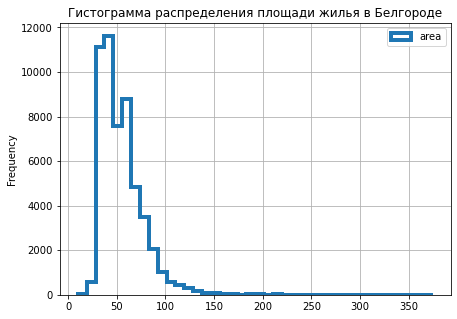

In [53]:
data_bgd.plot(kind='hist', y='area', histtype='step', bins=40, linewidth=4, grid=True, legend=True, figsize=(7,5))
plt.title('Гистограмма распределения площади жилья в Белгороде')
plt.show()

In [54]:
data_bgd['area'].describe()

count    52933.000000
mean        55.046854
std         22.348256
min         10.000000
25%         39.000000
50%         50.000000
75%         64.700000
max        375.000000
Name: area, dtype: float64

Из гистограммы и числового описания данных видно, что в Белгороде есть квартиры с площадью более 300 квадратных метров.

In [55]:
data_bgd[data_bgd['area'] > 300]

date     price  level  levels  rooms   area  kitchen_area  \
390336   2021-01-24  15900000     17      17      5  360.0          30.0   
7678975  2021-09-07   3200000      7       9      1  312.0           7.3   
8586335  2021-10-04   3800000      5      10      1  375.0           9.0   
11100798 2021-12-20  15500000     17      17      5  356.0          25.0   
11239468 2021-12-24  15500000     17      17      5  356.0          30.0   

           latitude  longitude building_type  ... postal_code  street_id  \
390336    50.610266  36.585398    монолитный  ...    308014.0   497145.0   
7678975   50.564652  36.561661   Не известно  ...    308004.0   158492.0   
8586335   50.567485  36.578559   Не известно  ...    308033.0   158492.0   
11100798  50.595128  36.572122   Не известно  ...    308015.0        NaN   
11239468  50.595128  36.572122   Не известно  ...    308015.0        NaN   

          region   house_id  price_per_meter  ratio_kitchen_total_area  \
390336        31   790765.0          44167.0                  0.083333   
7678975       31  2128056.0          10256.0                  0.023397   
8586335       31  1740349.0          10133.0                  0.024000   
11100798      31        NaN          43539.0                  0.070225   
11239468      31        NaN          43539.0                  0.084270   

          azimuth  distance_to_center  month_of_sale  day_of_week  
390336     355.29                 1.3              1            6  
7678975    207.84                 4.0              9            1  
8586335    191.22                 2.7             10            0  
11100798   267.73                 1.7             12            0  
11239468   267.73                 1.7             12            4  

[5 rows x 21 columns]

Таких объявлений оказалось всего 5. И двое из них вызывают некоторые вопросы. Во втором и третьем объявлении есть сильно несоответствие площади квартиры и цены. Их лучше удалить.

In [56]:
data_bgd = data_bgd.drop(index=[7678975, 8586335])
data_bgd[data_bgd['area'] > 300]

date     price  level  levels  rooms   area  kitchen_area  \
390336   2021-01-24  15900000     17      17      5  360.0          30.0   
11100798 2021-12-20  15500000     17      17      5  356.0          25.0   
11239468 2021-12-24  15500000     17      17      5  356.0          30.0   

           latitude  longitude building_type  ... postal_code  street_id  \
390336    50.610266  36.585398    монолитный  ...    308014.0   497145.0   
11100798  50.595128  36.572122   Не известно  ...    308015.0        NaN   
11239468  50.595128  36.572122   Не известно  ...    308015.0        NaN   

          region  house_id  price_per_meter  ratio_kitchen_total_area  \
390336        31  790765.0          44167.0                  0.083333   
11100798      31       NaN          43539.0                  0.070225   
11239468      31       NaN          43539.0                  0.084270   

          azimuth  distance_to_center  month_of_sale  day_of_week  
390336     355.29                 1.3              1            6  
11100798   267.73                 1.7             12            0  
11239468   267.73                 1.7             12            4  

[3 rows x 21 columns]

Построим теперь гистограмму распределение цен на жилье:

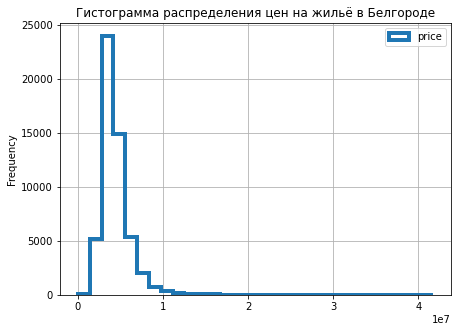

In [57]:
data_bgd.plot(kind='hist', y='price', histtype='step', bins=30, linewidth=4, grid=True, figsize=(7,5))
plt.title('Гистограмма распределения цен на жильё в Белгороде')
plt.show()

In [58]:
data_bgd['price'].describe()

count    5.293100e+04
mean     4.338330e+06
std      1.741869e+06
min      0.000000e+00
25%      3.290000e+06
50%      4.000000e+06
75%      4.950000e+06
max      4.170000e+07
Name: price, dtype: float64

In [59]:
data_bgd[data_bgd['price'] > 20000000]['price'].count()

33

In [60]:
data_bgd[data_bgd['price'] > 30000000]['price'].count()

6

In [61]:
data_bgd[data_bgd['price'] > 40000000]['price'].count()

1

In [62]:
data_bgd[data_bgd['price'] > 30000000]

date     price  level  levels  rooms   area  kitchen_area  \
5191453 2021-06-29  41700000      2       8      1   39.9          11.0   
6470714 2021-08-03  37000000     16      17      6  255.0          25.0   
6800214 2021-08-12  40000000     11      11      3  270.0          22.0   
8280989 2021-09-25  35400000      9      16      3  132.3          30.0   
9018013 2021-10-17  31500000     11      12      4  270.0          30.0   
9770924 2021-11-09  32000000     15      16      5  250.0          30.0   

          latitude  longitude building_type  ... postal_code  street_id  \
5191453  50.580162  36.569378     панельный  ...    308024.0   142358.0   
6470714  50.601931  36.595961   Не известно  ...    308001.0   245283.0   
6800214  50.579524  36.586211        другое  ...    308012.0   316154.0   
8280989  50.582970  36.576640   Не известно  ...    308027.0        NaN   
9018013  50.584915  36.582821        другое  ...    308009.0        NaN   
9770924  50.595169  36.581135   Не известно  ...    308009.0   536910.0   

         region   house_id  price_per_meter  ratio_kitchen_total_area  \
5191453      31  2674573.0        1045113.0                  0.275689   
6470714      31  1637065.0         145098.0                  0.098039   
6800214      31   659516.0         148148.0                  0.081481   
8280989      31        NaN         267574.0                  0.226757   
9018013      31        NaN         116667.0                  0.111111   
9770924      31   936572.0         128000.0                  0.120000   

         azimuth  distance_to_center  month_of_sale  day_of_week  
5191453   216.58                 2.4              6            1  
6470714    40.53                 1.1              8            1  
6800214   182.51                 1.4              8            3  
8280989   208.39                 1.6              9            5  
9018013   195.07                 1.1             10            6  
9770924   265.02                 0.7             11            1  

[6 rows x 21 columns]

В этом срезе все объявления кроме первого в целом выглядят правдоподобно. Первое удалим:

In [63]:
data_bgd = data_bgd.drop(index=[5191453])

Поскольку мы будем прогнозировать цену за квадратный метр, то взглянем еще на ее распределение:

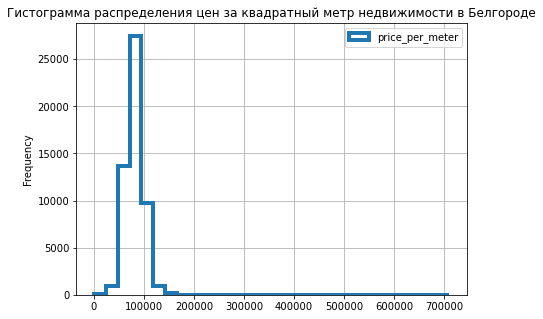

In [64]:
data_bgd.plot(kind='hist', y='price_per_meter', histtype='step', bins=30, linewidth=4, grid=True, figsize=(7,5))
plt.title('Гистограмма распределения цен за квадратный метр недвижимости в Белгороде')
plt.show()

Распределение далеко от нормального, поэтому можно либо его прологарифмировать, либо обрезать выбросы:

In [65]:
data_bgd = data_bgd[data_bgd['price'] < 20000000]

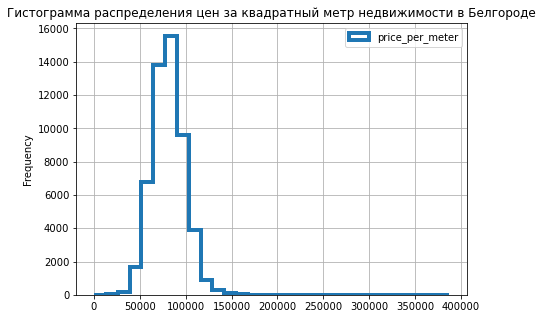

In [66]:
data_bgd.plot(kind='hist', y='price_per_meter', histtype='step', bins=30, linewidth=4, grid=True, figsize=(7,5))
plt.title('Гистограмма распределения цен за квадратный метр недвижимости в Белгороде')
plt.show()

Также взглянем на объявления с нулевой ценой:

In [67]:
data_bgd[data_bgd['price'] == 0]

date  price  level  levels  rooms   area  kitchen_area  \
4057089 2021-05-20      0      4      10      1   52.0          12.0   
4057304 2021-05-20      0      2       2      2   45.0           6.0   
4068623 2021-05-20      0      2       4      1   44.0          10.0   
4069622 2021-05-20      0      2      15      1   52.0          11.0   
4071958 2021-05-20      0      5       5      3   75.0          10.2   
4075345 2021-05-20      0      6       9      3  108.0          14.5   
4087646 2021-05-20      0      4      10      3   71.0           8.8   

          latitude  longitude building_type  ... postal_code  street_id  \
4057089  50.558042  36.565506   Не известно  ...    308036.0   540686.0   
4057304  50.536203  36.691348     кирпичный  ...    308510.0   370848.0   
4068623  50.576405  36.562088     кирпичный  ...    308019.0        NaN   
4069622  50.573746  36.562148    монолитный  ...    308019.0   333643.0   
4071958  50.582707  36.662493     кирпичный  ...    308013.0        NaN   
4075345  50.567401  36.589064     кирпичный  ...    308033.0   158492.0   
4087646  50.558847  36.564696     панельный  ...    308036.0   540686.0   

         region   house_id  price_per_meter  ratio_kitchen_total_area  \
4057089      31  1215590.0              0.0                  0.230769   
4057304      31   726638.0              0.0                  0.133333   
4068623      31        NaN              0.0                  0.227273   
4069622      31  1926801.0              0.0                  0.211538   
4071958      31        NaN              0.0                  0.136000   
4075345      31  1757293.0              0.0                  0.134259   
4087646      31  1047749.0              0.0                  0.123944   

         azimuth  distance_to_center  month_of_sale  day_of_week  
4057089   200.29                 4.1              5            3  
4057304   131.87                12.7              5            3  
4068623   219.98                 3.3              5            3  
4069622   216.29                 3.4              5            3  
4071958   104.99                 8.4              5            3  
4075345   177.73                 2.5              5            3  
4087646   201.40                 4.1              5            3  

[7 rows x 21 columns]

Явно что в них была допущена ошибка, поэтому удалим их:

In [68]:
data_bgd = data_bgd[data_bgd['price'] > 0]

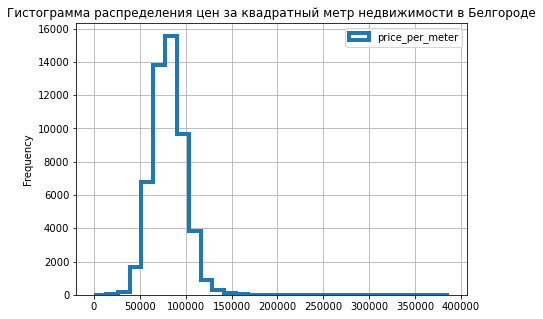

In [69]:
data_bgd.plot(kind='hist', y='price_per_meter', histtype='step', bins=30, linewidth=4, grid=True, figsize=(7,5))
plt.title('Гистограмма распределения цен за квадратный метр недвижимости в Белгороде')
plt.show()

В целом из анализа гистограммы и числового описания можно сделать следующие выводы:
- в среднем жилье в Белгороде стоит 4 млн рублей
- есть много объектов стоимостью выше 10 млн рублей
- всего пара дестков объектов стоимостью выше 20 млн рублей

Построим теперь гистограмму распределения числа комнат в недвижимости Белгорода:

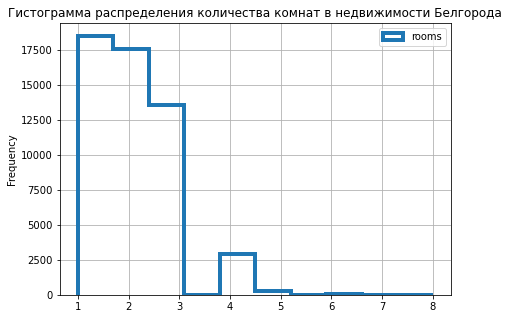

In [71]:
data_bgd.plot(kind='hist', y='rooms', histtype='step', bins=10, linewidth=4, grid=True, figsize=(7,5))
plt.title('Гистограмма распределения количества комнат в недвижимости Белгорода')
plt.show()

In [72]:
data_bgd['rooms'].describe()

count    52881.000000
mean         2.035362
std          0.939508
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          8.000000
Name: rooms, dtype: float64

Исходя из гистограммы и числового описания данных можно сделать вывод о том, что в основном вся недвижимость Белгорода - это квартиры от 1 до 3-х комнат. Есть некоторая доля 4-х комнатных квартир и даже есть квартиры с 8 комнатами.

### Какие факторы больше всего влияют на стоимость квартиры? Изучим, зависит ли цена от площади, числа комнат, удалённости от центра. Изучим зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом. Также изучим зависимость от даты размещения: дня недели, месяца.

**Изучим, зависит ли цена от площади, числа комнат, удалённости от центра.**

Возьмем срез с необходимыми нам величинами:

In [73]:
data_slice = data_bgd[['price', 'area', 'rooms', 'distance_to_center']]
data_slice.head()

price   area  rooms  distance_to_center
75    3880000   60.0      2                 2.6
292   3500000   57.7      2                 8.2
367   3950000   51.0      2                 3.8
1148  3400000   57.0      3                 1.9
1777  5007000  114.0      3                 3.5

Построим матрицу диаграмм рассеяния:

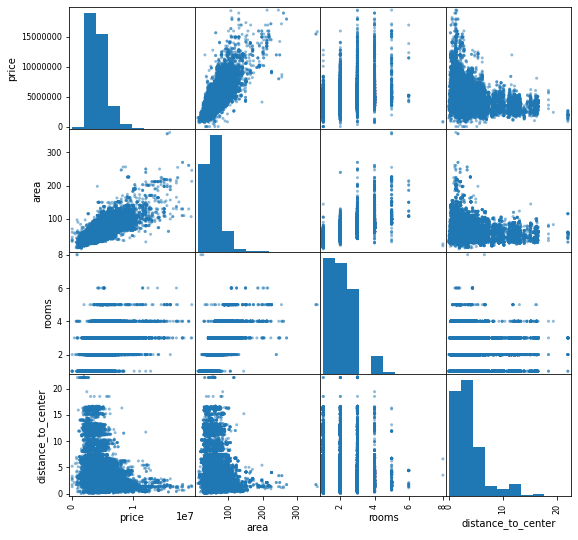

In [74]:
pd.plotting.scatter_matrix(data_slice, figsize=(9,9))
plt.show()

Выведем еще матрицу корреляции велечин:

In [75]:
data_slice.corr()

price      area     rooms  distance_to_center
price               1.000000  0.791595  0.513901           -0.247041
area                0.791595  1.000000  0.761378           -0.120185
rooms               0.513901  0.761378  1.000000           -0.108984
distance_to_center -0.247041 -0.120185 -0.108984            1.000000

**Вывод**

По матрице корреляции и по матрице диаграмм рассеяния видно что есть прямая зависимость между площадью и ценой, также присутствуют хоть и небольшая но прямая взаимосвязь между количеством комнат и ценой, а вот удаленность от центра влияет на цену лишь на значениях до 8км, что видно на графике между ценой и расстоянием.

**Изучим зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом.**

Категоризируем этажи недвижимости:

In [76]:
def category_level(row):
    if row['level'] == 1:
        return 'первый'
    if row['levels'] == row['level']:
        return 'последний'
    else:
        return 'другой'
    
data_bgd['category_level'] = data_bgd.apply(category_level, axis=1)
data_bgd.head()

date    price  level  levels  rooms   area  kitchen_area  \
75   2021-01-01  3880000      1       9      2   60.0           9.5   
292  2021-01-01  3500000      1       4      2   57.7          10.0   
367  2021-01-01  3950000      1       9      2   51.0           9.0   
1148 2021-01-01  3400000      1       5      3   57.0           9.0   
1777 2021-01-01  5007000      9      16      3  114.0          17.2   

       latitude  longitude building_type  ... street_id  region   house_id  \
75    50.569676  36.576500   Не известно  ...  473680.0      31  2138731.0   
292   50.582151  36.660419     кирпичный  ...  235193.0      31  2456500.0   
367   50.555684  36.575505     панельный  ...  142358.0      31  2484431.0   
1148  50.612312  36.576919     кирпичный  ...  549537.0      31  2818216.0   
1777  50.572646  36.561332       блочный  ...       NaN      31        NaN   

      price_per_meter  ratio_kitchen_total_area  azimuth  distance_to_center  \
75            64667.0                  0.158333   194.89                 2.6   
292           60659.0                  0.173310   106.03                 8.2   
367           77451.0                  0.176471   190.67                 3.8   
1148          59649.0                  0.157895   338.57                 1.9   
1777          43921.0                  0.150877   215.82                 3.5   

      month_of_sale  day_of_week  category_level  
75                1            4          первый  
292               1            4          первый  
367               1            4          первый  
1148              1            4          первый  
1777              1            4          другой  

[5 rows x 22 columns]

In [77]:
data_bgd.pivot_table(index='category_level', values='price', aggfunc=['mean', 'median'])

mean   median
                       price    price
category_level                       
другой          4.539534e+06  4200000
первый          3.757463e+06  3600000
последний       3.885718e+06  3600000

**Вывод**

Как и ожидалось, самые дешевый квартиры на первом этаже, средние цены имеют квартиры на последних этажах, а самые дорогие квартиры между ними.

**Изучим зависимость цены от даты размещения: дня недели, месяца**

In [78]:
data_bgd.pivot_table(index='day_of_week', values='price', aggfunc=['mean', 'median'])

mean   median
                    price    price
day_of_week                       
0            4.305102e+06  3950000
1            4.318765e+06  4000000
2            4.334455e+06  4000000
3            4.346758e+06  4000000
4            4.349406e+06  3999990
5            4.293927e+06  3970000
6            4.291868e+06  3960000

Цена в основном ниже в конце недели и со втроника по четверг растет.

In [79]:
data_bgd.pivot_table(index='month_of_sale', values='price', aggfunc=['mean', 'median'])

mean   median
                      price    price
month_of_sale                       
1              4.089624e+06  3770000
2              4.114359e+06  3800000
3              4.007609e+06  3780000
4              4.123845e+06  3800000
5              4.181584e+06  3890000
6              4.196600e+06  3850000
7              4.248084e+06  3900000
8              4.297652e+06  3950000
9              4.446355e+06  4100000
10             4.626905e+06  4300000
11             4.818930e+06  4450000
12             5.009192e+06  4570000

Поскольку данные лишь за год мы не можем достоверно судить о сезонности, но по таблице хорошо видно что цены на недвижимость в 2021 году равномерно росли в течение всего года.

Построим график изменения средней цены на недвижимость в Белгороде за год:

In [80]:
data_bgd_grouped = data_bgd.groupby('month_of_sale')['price'].mean()

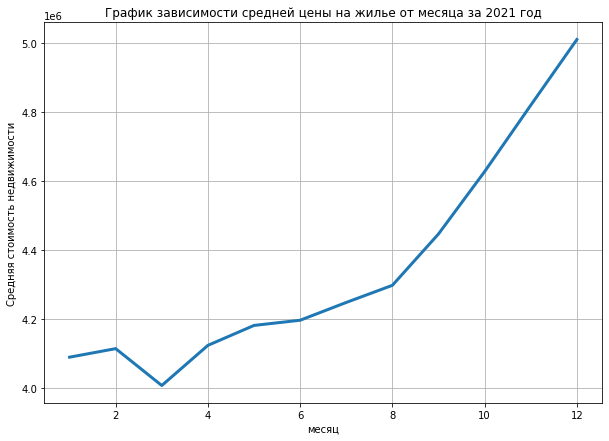

In [81]:
data_bgd_grouped.plot(grid=True, linewidth=3, figsize=(10,7), xlabel='месяц', ylabel='Средняя стоимость недвижимости')
plt.title('График зависимости средней цены на жилье от месяца за 2021 год')
plt.show()

Из данных и графика ярко выражен рост стоимости на недвижимость в Белгороде за год. Попробуем выяснить с чем связан такой быстрый рост. Можно предположить, что цены менялись из за изменения курса валют. Или изменение цен может быть связано с уменьшением заболеваемости населения коронавирусом.

Проверим эти предположения:

In [82]:
data_rub = pd.read_csv('USD_RUB.csv', decimal=',')
data_rub.head()

Дата     Цена    Откр.    Макс.     Мин.  Изм. %
0  30.12.2021  74.6539  74.0000  75.1295  74.0000   0,88%
1  29.12.2021  74.0000  73.7359  74.1919  73.5559   0,36%
2  28.12.2021  73.7359  73.4634  73.8769  73.3407   0,37%
3  27.12.2021  73.4634  73.6673  73.6684  73.1070  -0,28%
4  24.12.2021  73.6673  73.3072  73.7286  73.1447   0,49%

In [83]:
data_rub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Дата    255 non-null    object 
 1   Цена    255 non-null    float64
 2   Откр.   255 non-null    float64
 3   Макс.   255 non-null    float64
 4   Мин.    255 non-null    float64
 5   Изм. %  255 non-null    object 
dtypes: float64(4), object(2)
memory usage: 12.1+ KB


Оставим только интересующие нас столбцы:

In [84]:
data_rub.columns

Index(['Дата', 'Цена', 'Откр.', 'Макс.', 'Мин.', 'Изм. %'], dtype='object')

In [85]:
data_rub = data_rub.drop(['Откр.', 'Макс.', 'Мин.', 'Изм. %'], axis=1)

In [86]:
data_rub['Дата'] = pd.to_datetime(data_rub['Дата'])

In [87]:
data_rub['месяц'] = data_rub['Дата'].dt.month

In [88]:
data_rub.head()

Дата     Цена  месяц
0 2021-12-30  74.6539     12
1 2021-12-29  74.0000     12
2 2021-12-28  73.7359     12
3 2021-12-27  73.4634     12
4 2021-12-24  73.6673     12

In [89]:
data_rub_grouped = data_rub.groupby('месяц')['Цена'].mean()
data_rub_grouped

месяц
1     74.270468
2     73.896332
3     74.460285
4     75.054233
5     73.699350
6     73.157614
7     73.894357
8     73.675895
9     73.142817
10    71.683205
11    73.627285
12    73.872570
Name: Цена, dtype: float64

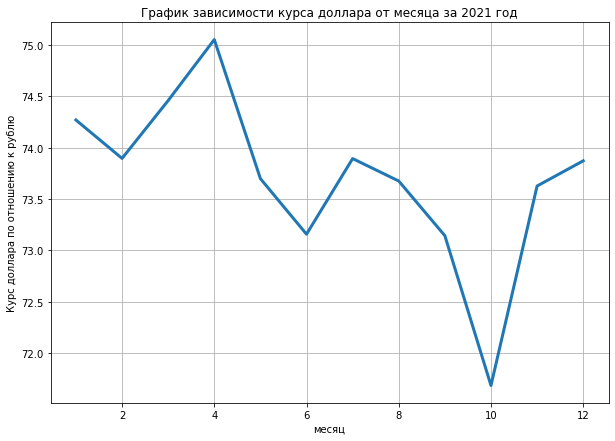

In [90]:
data_rub_grouped.plot(grid=True, linewidth=3, figsize=(10,7), xlabel='месяц', ylabel='Курс доллара по отношению к рублю')
plt.title('График зависимости курса доллара от месяца за 2021 год')
plt.show()

In [91]:
data_bgd_grouped_rub = pd.DataFrame(columns=['mean_price', 'mean_usd/rub'], index=range(1,13))
data_bgd_grouped_rub['mean_price'] = pd.Series(data_bgd_grouped)
data_bgd_grouped_rub['mean_usd/rub'] = pd.Series(data_rub_grouped)
data_bgd_grouped_rub

mean_price  mean_usd/rub
1   4.089624e+06     74.270468
2   4.114359e+06     73.896332
3   4.007609e+06     74.460285
4   4.123845e+06     75.054233
5   4.181584e+06     73.699350
6   4.196600e+06     73.157614
7   4.248084e+06     73.894357
8   4.297652e+06     73.675895
9   4.446355e+06     73.142817
10  4.626905e+06     71.683205
11  4.818930e+06     73.627285
12  5.009192e+06     73.872570

Найдем коэффициент корреляции Пирсона:

In [92]:
data_bgd_grouped_rub.corr()

mean_price  mean_usd/rub
mean_price      1.000000     -0.427859
mean_usd/rub   -0.427859      1.000000

**Проследим также была ли взаимосвязь рынка недвижимости с заболеваемостью людей в городе**

In [93]:
covid = pd.read_csv('covid.csv', sep=';', parse_dates=[0], index_col=[0])
covid.head()

Регион  Заражений  Выздоровлений  Смертей  \
Дата                                                                
2020-09-20        Томская обл.       6775           5554       79   
2020-09-26    Костромская обл.       4553           3329       67   
2021-02-09   Ямало-Ненецкий АО      47772          45810      625   
2020-12-15    Сахалинская обл.      13406          10292       11   
2020-09-21  Волгоградская обл.      14158          12376      131   

            Смертей за день  Заражений за день  Выздоровлений за день  
Дата                                                                   
2020-09-20                1                 62                     92  
2020-09-26                5                 54                     44  
2021-02-09                4                102                    121  
2020-12-15                0                142                    366  
2020-09-21                0                 95                     13

In [94]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 58718 entries, 2020-09-20 to 2021-04-20
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Регион                 58718 non-null  object
 1   Заражений              58718 non-null  int64 
 2   Выздоровлений          58718 non-null  int64 
 3   Смертей                58718 non-null  int64 
 4   Смертей за день        58718 non-null  int64 
 5   Заражений за день      58718 non-null  int64 
 6   Выздоровлений за день  58718 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 3.6+ MB


Сделаем срез для Белгорода:

In [95]:
covid_bgd = covid[(covid['Регион']=='Белгородская обл.') & (covid.index.year==2021)]
covid_bgd.head()

Регион  Заражений  Выздоровлений  Смертей  \
Дата                                                               
2021-11-05  Белгородская обл.      37553          34923      654   
2021-12-05  Белгородская обл.      37616          34996      656   
2021-10-05  Белгородская обл.      37488          34888      652   
2021-09-05  Белгородская обл.      37421          34859      650   
2021-04-28  Белгородская обл.      36623          34505      627   

            Смертей за день  Заражений за день  Выздоровлений за день  
Дата                                                                   
2021-11-05                2                 65                     35  
2021-12-05                2                 63                     73  
2021-10-05                2                 67                     29  
2021-09-05                2                 68                     17  
2021-04-28                2                 78                    131

In [96]:
covid_bgd.shape

(365, 7)

In [97]:
covid_bgd = covid_bgd.sort_values(by='Дата')
covid_bgd.head()

Регион  Заражений  Выздоровлений  Смертей  \
Дата                                                               
2021-01-01  Белгородская обл.      22007          20143      262   
2021-01-02  Белгородская обл.      27620          24920      375   
2021-01-03  Белгородская обл.      31541          28813      487   
2021-01-04  Белгородская обл.      34366          32221      565   
2021-01-05  Белгородская обл.      36845          34731      633   

            Смертей за день  Заражений за день  Выздоровлений за день  
Дата                                                                   
2021-01-01                4                190                    170  
2021-01-02                3                169                     78  
2021-01-03                2                 93                     25  
2021-01-04                3                 84                    189  
2021-01-05                2                 75                     97

In [98]:
covid_bgd['месяц'] = covid_bgd.index.month

In [99]:
covid_grouped_good = covid_bgd.groupby(by='месяц')['Выздоровлений'].mean()

In [100]:
covid_grouped_bad = covid_bgd.groupby(by='месяц')['Заражений'].mean()

In [101]:
covid_grouped = pd.DataFrame(columns=['Выздоравлений', 'Заражений'], index=range(1,13))
covid_grouped['Выздоравлений'] = pd.Series(covid_grouped_good)
covid_grouped['Заражений'] = pd.Series(covid_grouped_bad)
covid_grouped

Выздоравлений     Заражений
1    29485.258065  32497.903226
2    32692.107143  35993.964286
3    34338.322581  37301.741935
4    36214.633333  39052.933333
5    37184.741935  40336.612903
6    38712.300000  41634.500000
7    40310.322581  43585.516129
8    42519.741935  46392.516129
9    44990.100000  49162.933333
10   48107.000000  53690.548387
11   51843.033333  59807.200000
12   57995.322581  66090.322581

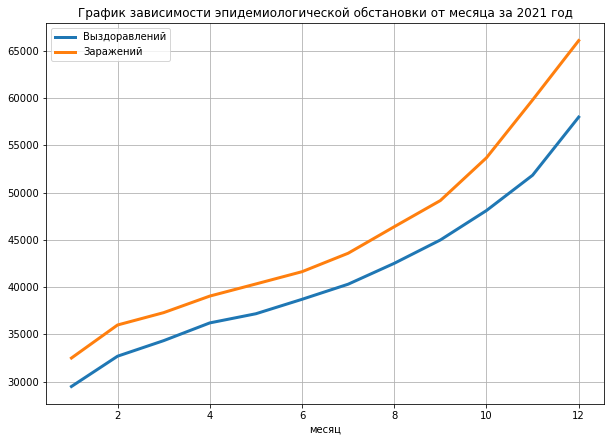

In [102]:
covid_grouped.plot(grid=True, linewidth=3, figsize=(10,7), xlabel='месяц')
plt.title('График зависимости эпидемиологической обстановки от месяца за 2021 год')
plt.show()

In [103]:
covid_grouped['Среднемесячная цена на недвижимость'] = pd.Series(data_bgd_grouped, index=covid_grouped.index)
covid_grouped

Выздоравлений     Заражений  Среднемесячная цена на недвижимость
1    29485.258065  32497.903226                         4.089624e+06
2    32692.107143  35993.964286                         4.114359e+06
3    34338.322581  37301.741935                         4.007609e+06
4    36214.633333  39052.933333                         4.123845e+06
5    37184.741935  40336.612903                         4.181584e+06
6    38712.300000  41634.500000                         4.196600e+06
7    40310.322581  43585.516129                         4.248084e+06
8    42519.741935  46392.516129                         4.297652e+06
9    44990.100000  49162.933333                         4.446355e+06
10   48107.000000  53690.548387                         4.626905e+06
11   51843.033333  59807.200000                         4.818930e+06
12   57995.322581  66090.322581                         5.009192e+06

Найдем коэффициенты корреляции Пирсона:

In [104]:
covid_grouped.corr()

Выздоравлений  Заражений  \
Выздоравлений                             1.000000   0.996799   
Заражений                                 0.996799   1.000000   
Среднемесячная цена на недвижимость       0.965613   0.980004   

                                     Среднемесячная цена на недвижимость  
Выздоравлений                                                   0.965613  
Заражений                                                       0.980004  
Среднемесячная цена на недвижимость                             1.000000

**Вывод**

Изучая зависимость средней цены на недвижимость в Белгороде от даты за 2021 год мы пришли к выводу, что цена в течение всего года постоянно росла. Такой рост цен на недвижимость нетипичен и мы предположили, что он связан с какими-то внешними факторами.

Одним из факторов влияния на рост цен является курс доллара по отношению к рубля. Мы импортировали данные курса доллара за 2021 год, построили график изменения его среднемесячной цены. Далее мы вычислили коэффициент корреляции Пирсона между курсом доллара и стоимостью недвижимости. Он равен -0.44 

Таким образом, можно утверждать что есть обратная связь между курсом доллара и стоимостью на недвижимость.

Также было предположение о том, что рост цен на недвижимость связан с уровнем заболеваемости в городе. Мы выгрузили официальную статистику заболеваемости и сгрупировали данные по месяцам. Исходя из полученных графиков и вычисленных коэффициентов корреляции Пирсона можно сделать вывод о том что в 2021 году на рост цен недвижимости очень сильно влиял фактор заболеваемости людей в городе. Объясняется это тем, что люди вкладывали деньги, боясь что экономика рухнет в ковидный год. Многие ещё помнят, как деньги горели в 1990-е». Молодые семьи, подстегнул рекордно низкий ипотечный процент и повышенный маткапитал. А поскольку рос спрос, росла и цена.

### Изучим предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выясним, какая область входит в центр.

Создадим столбец с расстоянием до центра в километрах: округлим до целых значений. 

После этого посчитаем среднюю цену для каждого километра. Построим график: он должен показывать, как цена зависит от удалённости от центра. 

Определите границу, где график сильно меняется, — это и будет центральная зона.

Округлим расстояние до километров:

In [105]:
data_bgd['round_distance_to_center'] = data_bgd['distance_to_center'].apply(round)
data_bgd.head()

date    price  level  levels  rooms   area  kitchen_area  \
75   2021-01-01  3880000      1       9      2   60.0           9.5   
292  2021-01-01  3500000      1       4      2   57.7          10.0   
367  2021-01-01  3950000      1       9      2   51.0           9.0   
1148 2021-01-01  3400000      1       5      3   57.0           9.0   
1777 2021-01-01  5007000      9      16      3  114.0          17.2   

       latitude  longitude building_type  ... region   house_id  \
75    50.569676  36.576500   Не известно  ...     31  2138731.0   
292   50.582151  36.660419     кирпичный  ...     31  2456500.0   
367   50.555684  36.575505     панельный  ...     31  2484431.0   
1148  50.612312  36.576919     кирпичный  ...     31  2818216.0   
1777  50.572646  36.561332       блочный  ...     31        NaN   

      price_per_meter  ratio_kitchen_total_area  azimuth  distance_to_center  \
75            64667.0                  0.158333   194.89                 2.6   
292           60659.0                  0.173310   106.03                 8.2   
367           77451.0                  0.176471   190.67                 3.8   
1148          59649.0                  0.157895   338.57                 1.9   
1777          43921.0                  0.150877   215.82                 3.5   

      month_of_sale  day_of_week  category_level  round_distance_to_center  
75                1            4          первый                         3  
292               1            4          первый                         8  
367               1            4          первый                         4  
1148              1            4          первый                         2  
1777              1            4          другой                         4  

[5 rows x 23 columns]

Построим график зависимости цен на жилье в зависимости от удаленности от центра города:

In [106]:
data_bgd_grouped = data_bgd.groupby('round_distance_to_center')['price'].mean()
data_bgd_grouped

round_distance_to_center
0     4.769048e+06
1     5.379803e+06
2     4.398331e+06
3     4.218229e+06
4     4.332032e+06
5     4.085664e+06
6     3.845230e+06
7     3.611610e+06
8     3.276095e+06
9     3.782010e+06
10    3.846535e+06
11    3.247316e+06
12    3.341563e+06
13    3.254875e+06
14    2.421212e+06
15    3.619598e+06
16    3.545003e+06
17    3.739412e+06
18    4.758333e+06
19    2.390000e+06
22    1.889667e+06
Name: price, dtype: float64

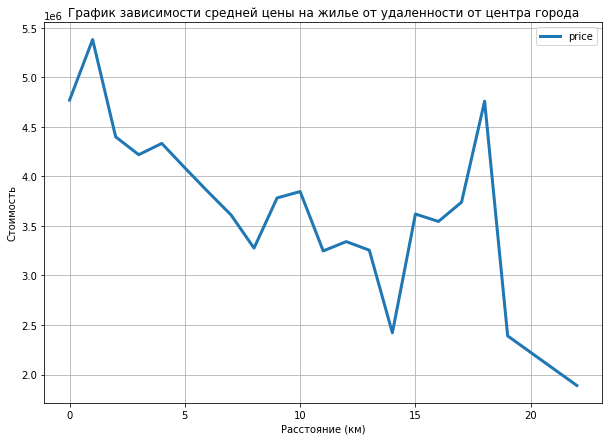

In [107]:
data_bgd_grouped.plot(grid=True, linewidth=3, legend=True, title='price_per_km', figsize=(10,7), xlabel='Расстояние (км)', ylabel='Стоимость')
plt.title('График зависимости средней цены на жилье от удаленности от центра города')
plt.show()

**Вывод**

Для всех объявлений Белгорода мы рассчитали среднюю цену в зависимости от удаленности от центра города. График показывает что происходит резкое изменение цены в районе 7-8 километров от центра. Далее есть резкий рост на 16-18 километрах, который может быть связан с перспективными частными секторами.

## Моделирование

В этом разделе мы будем создавать модель машинного обучения, для прогнозирования цен на недвижимость в Белгороде.

Поскольку будет решаться задача регрессии мы будем использовать как классические модели машинного обуччения, такие модели как линейная регрессия, решающее дерево, случайный лес, так и современные как градиентный бустинг.

### Подготовка данных

Поскольку для обучения моделей мы будем использовать кросс-валидацию, то данные разделим только на тренировочную и тестовую выборки.

In [108]:
data_bgd.columns

Index(['date', 'price', 'level', 'levels', 'rooms', 'area', 'kitchen_area',
       'latitude', 'longitude', 'building_type', 'object_type', 'postal_code',
       'street_id', 'region', 'house_id', 'price_per_meter',
       'ratio_kitchen_total_area', 'azimuth', 'distance_to_center',
       'month_of_sale', 'day_of_week', 'category_level',
       'round_distance_to_center'],
      dtype='object')

In [124]:
features = data_bgd.drop(['date', 'price', 'latitude', 'longitude', 'postal_code', 
                          'street_id', 'region', 'house_id', 'round_distance_to_center', 'day_of_week', 'price_per_meter'], axis=1)
target = data_bgd['price_per_meter']

In [125]:
features.columns

Index(['level', 'levels', 'rooms', 'area', 'kitchen_area', 'building_type',
       'object_type', 'ratio_kitchen_total_area', 'azimuth',
       'distance_to_center', 'month_of_sale', 'category_level'],
      dtype='object')

In [126]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=27)

print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(42304, 12)
(42304,)
(10577, 12)
(10577,)


In [127]:
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

### Линейная регрессия

Линейная регрессия основана на подборе коэффициентов, поэтому первоначально необходимо преобразовать все категориальные признаки в числа.

In [128]:
features_train_ohe = pd.get_dummies(features_train, drop_first=True)
features_train_ohe.shape

(42304, 18)

In [129]:
model = LinearRegression()
params = {}
grid = GridSearchCV(model, params, scoring=mse_scorer)
grid.fit(features_train_ohe, target_train)

final_rmse = (np.abs(grid.best_score_)) ** 0.5
print('rmse_cross_valid:', final_rmse)

rmse_cross_valid: 12450.537466826378


Найдем коэффициенты линейной регрессии для интепретации модели:

In [130]:
coeffs = grid.best_estimator_.coef_
coeffs

array([ 1.89286906e+02,  6.23384312e+02, -4.61287176e+03, -1.14863000e+02,
       -1.12665258e+02,  4.26411221e+04, -2.72083379e+00, -1.32827920e+03,
        1.73667904e+03,  1.07948683e+03, -1.99754857e+04,  9.59151908e+02,
       -2.45525442e+03, -1.44343375e+03, -1.87443643e+03,  3.40889897e+03,
       -6.03005334e+03, -4.57204022e+03])

In [131]:
interpretation_linear = pd.Series(coeffs, index=features_train_ohe.columns)
interpretation_linear.sort_values(ascending=False)

ratio_kitchen_total_area    42641.122103
object_type_новостройка      3408.898965
month_of_sale                1736.679039
building_type_блочный        1079.486833
building_type_другое          959.151908
levels                        623.384312
level                         189.286906
azimuth                        -2.720834
kitchen_area                 -112.665258
area                         -114.863000
distance_to_center          -1328.279200
building_type_монолитный    -1443.433749
building_type_панельный     -1874.436435
building_type_кирпичный     -2455.254420
category_level_последний    -4572.040224
rooms                       -4612.871756
category_level_первый       -6030.053341
building_type_деревянный   -19975.485735
dtype: float64

### Дерево решений

In [132]:
model = DecisionTreeRegressor(random_state=27)

params = {
    'max_depth': range(1, 40)
    #'min_samples_split': [1, 2, 3],
    #'min_samples_leaf': [1, 2, 3]
}

grid = GridSearchCV(model, params, scoring=mse_scorer)
grid.fit(features_train_ohe, target_train)

GridSearchCV(estimator=DecisionTreeRegressor(random_state=27),
             param_grid={'max_depth': range(1, 40)},
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [133]:
final_rmse = (np.abs(grid.best_score_)) ** 0.5
print('rmse_cross_valid:', final_rmse)

rmse_cross_valid: 11351.273969117576


In [134]:
grid.best_params_

{'max_depth': 15}

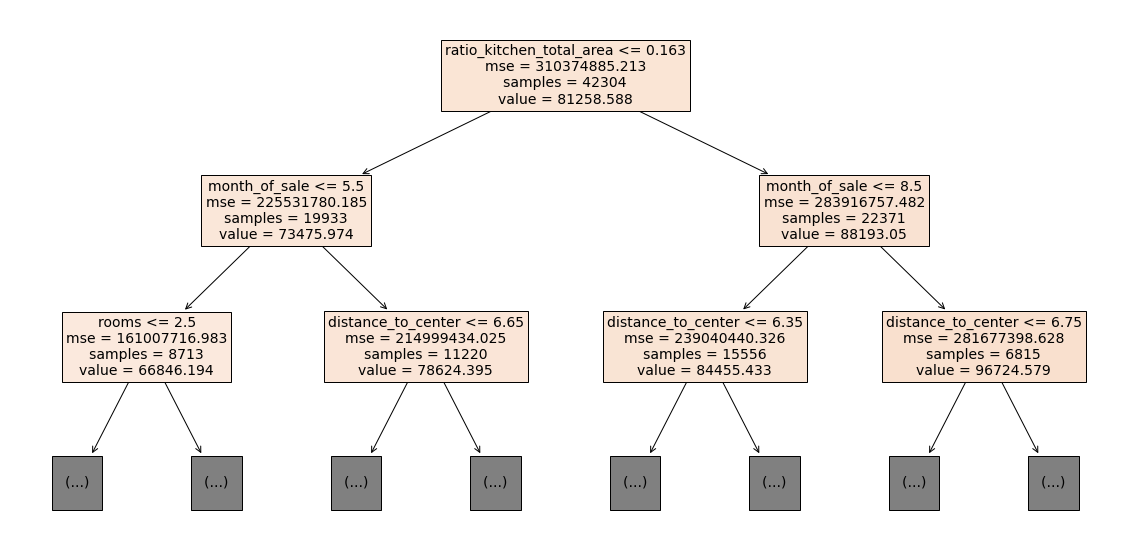

In [136]:
plt.figure(figsize=(20,10))
tree.plot_tree(grid.best_estimator_, filled=True, fontsize=14, feature_names=features_train_ohe.columns, max_depth=2)
plt.show()

### Случайный лес

In [139]:
model = RandomForestRegressor()

params = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [15]
    
}

grid = GridSearchCV(model, params, scoring=mse_scorer)
grid.fit(features_train_ohe, target_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [15], 'n_estimators': [100, 500, 1000]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [140]:
grid.best_params_

{'max_depth': 15, 'n_estimators': 1000}

In [141]:
final_rmse = (np.abs(grid.best_score_)) ** 0.5
print('rmse_cross_valid:', final_rmse)

rmse_cross_valid: 9013.462903426775


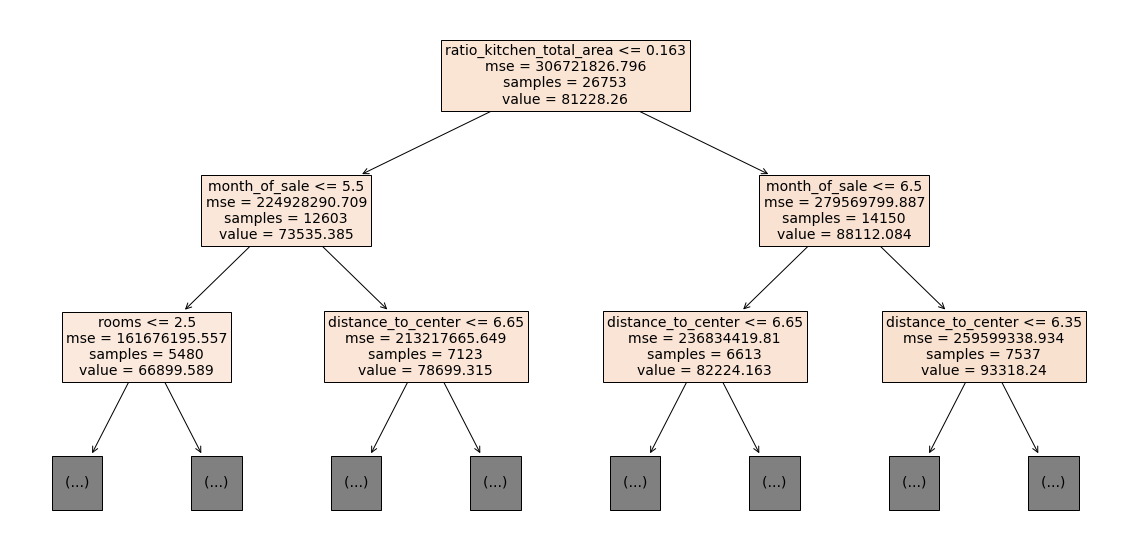

In [142]:
plt.figure(figsize=(20,10))
tree.plot_tree(grid.best_estimator_.estimators_[7], filled=True, fontsize=14, feature_names=features_train_ohe.columns, max_depth=2)
plt.show()

### CatBoost

In [143]:
features_train.columns

Index(['level', 'levels', 'rooms', 'area', 'kitchen_area', 'building_type',
       'object_type', 'ratio_kitchen_total_area', 'azimuth',
       'distance_to_center', 'month_of_sale', 'category_level'],
      dtype='object')

**Запустим модель на дефолтных гиперпараметрах:**

In [146]:
params = {}
params['loss_function'] = 'RMSE'
params['random_seed'] = 27
params['eval_metric'] = 'RMSE'
params['custom_metric'] = ['MAE', 'MAPE']

cbr_cv_data = cv(
    params = params,
    pool = Pool(features_train, label=target_train, cat_features=['building_type', 'object_type', 'level',
                                                                  'month_of_sale', 'category_level']),
    fold_count = 5,
    shuffle = True,
    partition_random_seed = 0,
    plot = True,
    verbose = False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 10098.47601
bestIteration = 999

Training on fold [1/5]

bestTest = 9956.928284
bestIteration = 999

Training on fold [2/5]

bestTest = 10536.0645
bestIteration = 999

Training on fold [3/5]

bestTest = 10160.45618
bestIteration = 999

Training on fold [4/5]

bestTest = 9804.41877
bestIteration = 999



In [147]:
cbr_cv_data.head()

iterations  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  train-RMSE-std  \
0           0    80751.093858     203.404370     80751.122552       49.691965   
1           1    78426.588284     202.851091     78426.144529       48.412377   
2           2    76167.699817     204.169730     76167.230979       47.415013   
3           3    73981.204701     203.975413     73980.577989       46.514971   
4           4    71867.383220     204.248605     71866.466511       45.421287   

   test-MAE-mean  test-MAE-std  train-MAE-mean  train-MAE-std  test-MAPE-mean  \
0   78827.105632    173.665644    78826.911436      42.284166        0.972382   
1   76468.611571    172.422679    76468.019839      40.940765        0.945876   
2   74179.828206    172.987934    74179.275366      39.646857        0.920421   
3   71959.040861    172.105896    71958.352629      38.435894        0.895683   
4   69807.263623    171.656979    69806.474625      37.289143        0.871548   

   test-MAPE-std  train-MAPE-mean  train-MAPE-std  
0       0.002260         0.972373        0.000575  
1       0.004698         0.945864        0.001187  
2       0.007087         0.920410        0.001778  
3       0.009372         0.895672        0.002352  
4       0.011433         0.871533        0.002861

In [148]:
best_value = np.min(cbr_cv_data['test-RMSE-mean'])
best_iter = np.argmin(cbr_cv_data['test-RMSE-mean'])
best_mape = cbr_cv_data.loc[best_iter, 'test-MAPE-mean']
best_mae = cbr_cv_data.loc[best_iter, 'test-MAE-mean']
print('Лучшее значение RMSE =', best_value)
print('Лучшее значение MAPE =', best_mape)
print('Лучшее значение MAE =', best_mae)
print('лучшая итерация -', best_iter)

Лучшее значение RMSE = 10111.2687483603
Лучшее значение MAPE = 0.23661110984446282
Лучшее значение MAE = 7212.230866167377
лучшая итерация - 999


In [149]:
cbr_cv_data.loc[best_iter]

iterations           999.000000
test-RMSE-mean     10111.268748
test-RMSE-std        274.322974
train-RMSE-mean     9658.319384
train-RMSE-std        67.417746
test-MAE-mean       7212.230866
test-MAE-std         104.074399
train-MAE-mean      6967.145275
train-MAE-std         27.488814
test-MAPE-mean         0.236611
test-MAPE-std          0.089504
train-MAPE-mean        0.230678
train-MAPE-std         0.022956
Name: 999, dtype: float64

**Настроим параметры количество итераций = 3000, обучение = 0.5:**

In [164]:
params = {}
params['loss_function'] = 'RMSE'
params['iterations'] = 3000
params['random_seed'] = 27
params['learning_rate'] = 0.5
params['eval_metric'] = 'RMSE'
params['custom_metric'] = ['MAE', 'MAPE']

cbr_cv_data = cv(
    params = params,
    pool = Pool(features_train, label=target_train, cat_features=['building_type', 'object_type', 'level',
                                                                  'month_of_sale', 'category_level']),
    fold_count = 5,
    shuffle = True,
    partition_random_seed = 0,
    plot = True,
    verbose = False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 7994.718763
bestIteration = 2998

Training on fold [1/5]

bestTest = 8182.521133
bestIteration = 2949

Training on fold [2/5]

bestTest = 8613.353282
bestIteration = 2952

Training on fold [3/5]

bestTest = 8244.795043
bestIteration = 2988

Training on fold [4/5]

bestTest = 7945.965674
bestIteration = 2987



In [165]:
cbr_cv_data.head()

iterations  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  train-RMSE-std  \
0           0    43915.595909     216.870773     43911.186682       35.225424   
1           1    25718.824997     279.479343     25716.445824      107.125680   
2           2    17802.548057     276.383665     17772.194827      117.636918   
3           3    14098.568536     277.638324     14094.243007       57.966542   
4           4    12811.056130     259.868927     12805.601549       49.847422   

   test-MAE-mean  test-MAE-std  train-MAE-mean  train-MAE-std  test-MAPE-mean  \
0   40797.732705    170.043717    40794.554404      24.003546        0.547134   
1   21460.371702    205.262328    21461.272349      37.375507        0.343945   
2   13566.356105    178.826152    13545.931877     100.301712        0.276027   
3   10190.784683    167.676011    10202.070788      38.587596        0.254029   
4    9173.586305    146.960945     9183.334597      47.696059        0.253113   

   test-MAPE-std  train-MAPE-mean  train-MAPE-std  
0       0.039797         0.546999        0.010122  
1       0.060101         0.342901        0.015440  
2       0.073239         0.275451        0.019474  
3       0.079048         0.253331        0.021409  
4       0.084387         0.250084        0.021254

In [167]:
best_value = np.min(cbr_cv_data['test-RMSE-mean'])
best_iter = np.argmin(cbr_cv_data['test-RMSE-mean'])
best_mape = cbr_cv_data.loc[best_iter, 'test-MAPE-mean']
best_mae = cbr_cv_data.loc[best_iter, 'test-MAE-mean']
print('Лучшее значение RMSE =', best_value)
print('Лучшее значение MAPE =', best_mape)
print('Лучшее значение MAE =', best_mae)
print('лучшая итерация -', best_iter)

Лучшее значение RMSE = 8197.288132278354
Лучшее значение MAPE = 0.21322773005366455
Лучшее значение MAE = 5231.010278302053
лучшая итерация - 2988


In [168]:
cbr_cv_data.loc[best_iter]

iterations         2988.000000
test-RMSE-mean     8197.288132
test-RMSE-std       264.179321
train-RMSE-mean    3816.715059
train-RMSE-std       25.949097
test-MAE-mean      5231.010278
test-MAE-std         71.045884
train-MAE-mean     2682.183319
train-MAE-std        22.349139
test-MAPE-mean        0.213228
test-MAPE-std         0.091343
train-MAPE-mean       0.097245
train-MAPE-std        0.013401
Name: 2988, dtype: float64

**Настроим параметры количество итераций = 5000, обучение = 0.1:**

In [173]:
params = {}
params['loss_function'] = 'RMSE'
params['iterations'] = 5000
params['random_seed'] = 27
params['learning_rate'] = 0.1
params['eval_metric'] = 'RMSE'
params['custom_metric'] = ['MAE', 'MAPE']

cbr_cv_data = cv(
    params = params,
    pool = Pool(features_train, label=target_train, cat_features=['building_type', 'object_type', 'level',
                                                                  'month_of_sale', 'category_level']),
    fold_count = 5,
    shuffle = True,
    partition_random_seed = 0,
    plot = True,
    verbose = False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 8051.939664
bestIteration = 4991

Training on fold [1/5]

bestTest = 8102.345594
bestIteration = 4992

Training on fold [2/5]

bestTest = 8667.333077
bestIteration = 4999

Training on fold [3/5]

bestTest = 8234.293236
bestIteration = 4999

Training on fold [4/5]

bestTest = 8002.021878
bestIteration = 4999



In [174]:
cbr_cv_data.head()

iterations  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  train-RMSE-std  \
0           0    75174.285003     204.077227     75173.898614       47.167498   
1           1    68014.685187     202.844708     68012.751527       43.315467   
2           2    61576.947277     206.643432     61573.755415       39.839328   
3           3    55820.829925     205.812652     55817.318147       38.588809   
4           4    50666.210542     198.707165     50662.586653       47.686428   

   test-MAE-mean  test-MAE-std  train-MAE-mean  train-MAE-std  test-MAPE-mean  \
0   73153.811700    171.788448    73153.153120      39.177267        0.908616   
1   65859.430550    168.589481    65857.522457      35.169184        0.826826   
2   59293.124784    171.135879    59290.462109      31.810873        0.754173   
3   53385.335364    169.227110    53382.758908      28.579128        0.688929   
4   48076.634012    169.814287    48074.537781      26.564076        0.630506   

   test-MAPE-std  train-MAPE-mean  train-MAPE-std  
0       0.007954         0.908588        0.002021  
1       0.015368         0.826778        0.003884  
2       0.022100         0.754137        0.005570  
3       0.028221         0.688899        0.007101  
4       0.033344         0.630526        0.008589

In [175]:
best_value = np.min(cbr_cv_data['test-RMSE-mean'])
best_iter = np.argmin(cbr_cv_data['test-RMSE-mean'])
best_mape = cbr_cv_data.loc[best_iter, 'test-MAPE-mean']
best_mae = cbr_cv_data.loc[best_iter, 'test-MAE-mean']
print('Лучшее значение RMSE =', best_value)
print('Лучшее значение MAPE =', best_mape)
print('Лучшее значение MAE =', best_mae)
print('лучшая итерация -', best_iter)

Лучшее значение RMSE = 8211.672199464641
Лучшее значение MAPE = 0.21455974580310225
Лучшее значение MAE = 5378.7150332807905
лучшая итерация - 4999


In [176]:
cbr_cv_data.loc[best_iter]

iterations         4999.000000
test-RMSE-mean     8211.672199
test-RMSE-std       269.000748
train-RMSE-mean    5553.000599
train-RMSE-std       32.104839
test-MAE-mean      5378.715033
test-MAE-std         60.814341
train-MAE-mean     3898.594428
train-MAE-std        31.491531
test-MAPE-mean        0.214560
test-MAPE-std         0.091117
train-MAPE-mean       0.152593
train-MAPE-std        0.018101
Name: 4999, dtype: float64

## Тест

In [180]:
model = CatBoostRegressor(loss_function = 'RMSE', iterations=2988, learning_rate=0.5, custom_metric=['MAE', 'MAPE'], random_seed=27)

model.fit(features_train, target_train, cat_features=['building_type', 'object_type', 'level', 'month_of_sale', 'category_level'], 
          plot = True, verbose = False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [182]:
predictions = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions) ** 0.5
mape = mean_absolute_percentage_error(target_test, predictions)
mae = mean_absolute_error(target_test, predictions)
print(f'RMSE = {rmse}')
print(f'MAPE = {mape}')
print(f'MAE = {mae}')

RMSE = 7287.156983432588
MAPE = 0.1517710879218899
MAE = 4766.575064737174


In [99]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [183]:
import graphviz

In [184]:
tree = model.plot_tree(tree_idx=0, pool=Pool(features_train, label=target_train, cat_features=['building_type', 'object_type', 'level', 'month_of_sale', 'category_level']))

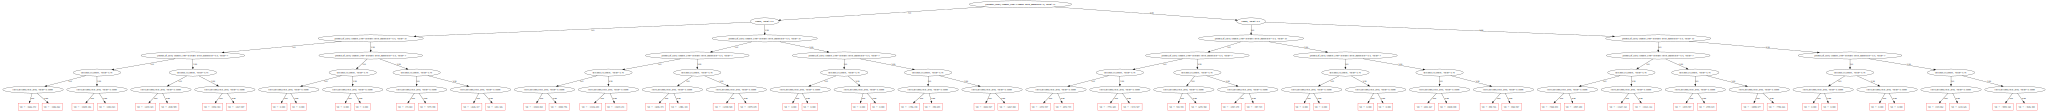

In [185]:
tree

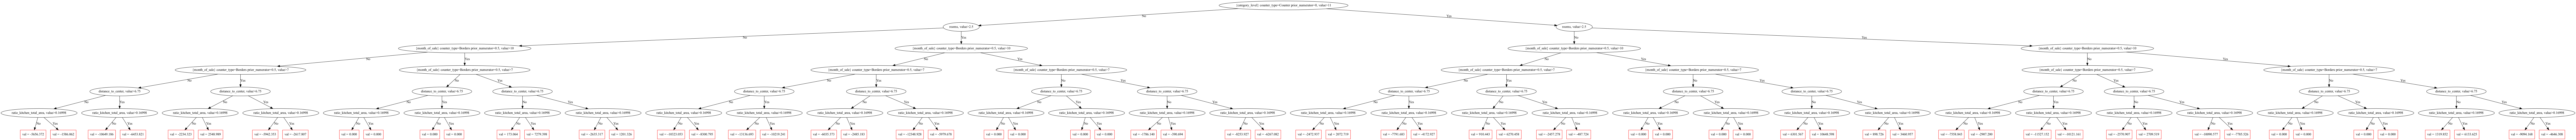

In [186]:
import IPython
IPython.display.display_png(tree)

## Модернизация моделей с учетом полученных выводов о взаимосвязи рынка недвижимости с фактороми: курс доллара, заболеваемость

### Подготовим новые данные

In [187]:
data_bgd.columns

Index(['date', 'price', 'level', 'levels', 'rooms', 'area', 'kitchen_area',
       'latitude', 'longitude', 'building_type', 'object_type', 'postal_code',
       'street_id', 'region', 'house_id', 'price_per_meter',
       'ratio_kitchen_total_area', 'azimuth', 'distance_to_center',
       'month_of_sale', 'day_of_week', 'category_level',
       'round_distance_to_center'],
      dtype='object')

In [188]:
data_bgd.head()

date    price  level  levels  rooms   area  kitchen_area  \
75   2021-01-01  3880000      1       9      2   60.0           9.5   
292  2021-01-01  3500000      1       4      2   57.7          10.0   
367  2021-01-01  3950000      1       9      2   51.0           9.0   
1148 2021-01-01  3400000      1       5      3   57.0           9.0   
1777 2021-01-01  5007000      9      16      3  114.0          17.2   

       latitude  longitude building_type  ... region   house_id  \
75    50.569676  36.576500   Не известно  ...     31  2138731.0   
292   50.582151  36.660419     кирпичный  ...     31  2456500.0   
367   50.555684  36.575505     панельный  ...     31  2484431.0   
1148  50.612312  36.576919     кирпичный  ...     31  2818216.0   
1777  50.572646  36.561332       блочный  ...     31        NaN   

      price_per_meter  ratio_kitchen_total_area  azimuth  distance_to_center  \
75            64667.0                  0.158333   194.89                 2.6   
292           60659.0                  0.173310   106.03                 8.2   
367           77451.0                  0.176471   190.67                 3.8   
1148          59649.0                  0.157895   338.57                 1.9   
1777          43921.0                  0.150877   215.82                 3.5   

      month_of_sale  day_of_week  category_level  round_distance_to_center  
75                1            4          первый                         3  
292               1            4          первый                         8  
367               1            4          первый                         4  
1148              1            4          первый                         2  
1777              1            4          другой                         4  

[5 rows x 23 columns]

Напишем функцию для заполнения новых столбцов данными:

In [189]:
data_rub_grouped

месяц
1     74.270468
2     73.896332
3     74.460285
4     75.054233
5     73.699350
6     73.157614
7     73.894357
8     73.675895
9     73.142817
10    71.683205
11    73.627285
12    73.872570
Name: Цена, dtype: float64

In [190]:
covid_grouped = covid_grouped.drop('Среднемесячная цена на недвижимость', axis=1)
covid_grouped 

Выздоравлений     Заражений
1    29485.258065  32497.903226
2    32692.107143  35993.964286
3    34338.322581  37301.741935
4    36214.633333  39052.933333
5    37184.741935  40336.612903
6    38712.300000  41634.500000
7    40310.322581  43585.516129
8    42519.741935  46392.516129
9    44990.100000  49162.933333
10   48107.000000  53690.548387
11   51843.033333  59807.200000
12   57995.322581  66090.322581

In [191]:
def update_data(row):
    num = row['month_of_sale']
    row['covid_good'] = covid_grouped.loc[num, 'Выздоравлений']
    row['covid_bad'] = covid_grouped.loc[num, 'Заражений']
    row['dollar'] = data_rub_grouped.loc[num]
    return row

In [192]:
features = features.apply(update_data, axis=1)
features.head()

level  levels  rooms   area  kitchen_area building_type  object_type  \
75        1       9      2   60.0           9.5   Не известно  новостройка   
292       1       4      2   57.7          10.0     кирпичный  новостройка   
367       1       9      2   51.0           9.0     панельный  новостройка   
1148      1       5      3   57.0           9.0     кирпичный  новостройка   
1777      9      16      3  114.0          17.2       блочный    вторичное   

      ratio_kitchen_total_area  azimuth  distance_to_center  month_of_sale  \
75                    0.158333   194.89                 2.6              1   
292                   0.173310   106.03                 8.2              1   
367                   0.176471   190.67                 3.8              1   
1148                  0.157895   338.57                 1.9              1   
1777                  0.150877   215.82                 3.5              1   

     category_level    covid_good     covid_bad     dollar  
75           первый  29485.258065  32497.903226  74.270468  
292          первый  29485.258065  32497.903226  74.270468  
367          первый  29485.258065  32497.903226  74.270468  
1148         первый  29485.258065  32497.903226  74.270468  
1777         другой  29485.258065  32497.903226  74.270468

In [193]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=27)

print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(42304, 15)
(42304,)
(10577, 15)
(10577,)


In [194]:
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

### Линейная регрессия

Линейная регрессия основана на подборе коэффициентов, поэтому первоначально необходимо преобразовать все категориальные признаки в числа.

In [195]:
features_train_ohe = pd.get_dummies(features_train, drop_first=True)
features_train_ohe.shape

(42304, 21)

In [196]:
model = LinearRegression()
params = {}
grid = GridSearchCV(model, params, scoring=mse_scorer)
grid.fit(features_train_ohe, target_train)

final_rmse = (np.abs(grid.best_score_)) ** 0.5
print('rmse_cross_valid:', final_rmse)

rmse_cross_valid: 12417.72807080411


In [197]:
features_test_ohe = pd.get_dummies(features_test, drop_first=True)
model = grid.best_estimator_
predictions = model.predict(features_test_ohe)

mape = mean_absolute_percentage_error(target_test, predictions)
print('mape:', mape)

mape: 0.20898989866272505


Найдем коэффициенты линейной регрессии для интепретации модели:

In [198]:
coeffs = grid.best_estimator_.coef_
coeffs

array([ 1.83851184e+02,  6.24492028e+02, -4.62854573e+03, -1.15756542e+02,
       -1.11732558e+02,  4.27886975e+04, -2.71689880e+00, -1.32712822e+03,
        3.97175844e+02,  8.87353057e-01, -2.27275665e-01, -4.03968779e+01,
        1.25203086e+03, -2.01591696e+04,  1.22945560e+03, -2.22130008e+03,
       -1.23852992e+03, -1.62627597e+03,  3.48990260e+03, -6.04055633e+03,
       -4.57076313e+03])

In [199]:
interpretation_linear = pd.Series(coeffs, index=features_train_ohe.columns)
interpretation_linear.sort_values(ascending=False)

ratio_kitchen_total_area    42788.697508
object_type_новостройка      3489.902597
building_type_блочный        1252.030859
building_type_другое         1229.455599
levels                        624.492028
month_of_sale                 397.175844
level                         183.851184
covid_good                      0.887353
covid_bad                      -0.227276
azimuth                        -2.716899
dollar                        -40.396878
kitchen_area                 -111.732558
area                         -115.756542
building_type_монолитный    -1238.529919
distance_to_center          -1327.128222
building_type_панельный     -1626.275967
building_type_кирпичный     -2221.300081
category_level_последний    -4570.763125
rooms                       -4628.545734
category_level_первый       -6040.556328
building_type_деревянный   -20159.169558
dtype: float64

### Дерево решений

In [205]:
model = DecisionTreeRegressor(random_state=27)

params = {
    'max_depth': range(1, 40)
    #'min_samples_split': [1, 2, 3],
    #'min_samples_leaf': [1, 2, 3]
}

grid = GridSearchCV(model, params, scoring=mse_scorer)
grid.fit(features_train_ohe, target_train)

GridSearchCV(estimator=DecisionTreeRegressor(random_state=27),
             param_grid={'max_depth': range(1, 40)},
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [206]:
final_rmse = (np.abs(grid.best_score_)) ** 0.5
print('rmse_cross_valid:', final_rmse)

rmse_cross_valid: 11454.300920164154


In [207]:
grid.best_params_

{'max_depth': 31}

### Случайный лес

In [209]:
model = RandomForestRegressor()

params = {
    'n_estimators': [1000],
    'max_depth': [31]
    
}

grid = GridSearchCV(model, params, scoring=mse_scorer)
grid.fit(features_train_ohe, target_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [31], 'n_estimators': [1000]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [210]:
grid.best_params_

{'max_depth': 31, 'n_estimators': 1000}

In [211]:
final_rmse = (np.abs(grid.best_score_)) ** 0.5
print('rmse_cross_valid:', final_rmse)

rmse_cross_valid: 8321.197216563627


### CatBoost

In [212]:
features_train.columns

Index(['level', 'levels', 'rooms', 'area', 'kitchen_area', 'building_type',
       'object_type', 'ratio_kitchen_total_area', 'azimuth',
       'distance_to_center', 'month_of_sale', 'category_level', 'covid_good',
       'covid_bad', 'dollar'],
      dtype='object')

**Запустим модель на дефолтных гиперпараметрах:**

In [213]:
params = {}
params['loss_function'] = 'RMSE'
params['random_seed'] = 27
params['eval_metric'] = 'RMSE'
params['custom_metric'] = ['MAE', 'MAPE']

cbr_cv_data = cv(
    params = params,
    pool = Pool(features_train, label=target_train, cat_features=['building_type', 'object_type', 'level',
                                                                  'month_of_sale', 'category_level']),
    fold_count = 5,
    shuffle = True,
    partition_random_seed = 0,
    plot = True,
    verbose = False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 10066.35784
bestIteration = 999

Training on fold [1/5]

bestTest = 9905.681663
bestIteration = 999

Training on fold [2/5]

bestTest = 10514.54052
bestIteration = 999

Training on fold [3/5]

bestTest = 10132.76829
bestIteration = 999

Training on fold [4/5]

bestTest = 9827.055656
bestIteration = 999



In [214]:
cbr_cv_data.head()

iterations  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  train-RMSE-std  \
0           0    80733.871156     204.472233     80733.851145       49.608131   
1           1    78398.551645     205.059326     78398.762648       48.499060   
2           2    76132.033333     205.589585     76132.101702       47.367333   
3           3    73947.649402     207.105733     73948.033319       46.441105   
4           4    71821.341457     208.975367     71821.866357       44.639995   

   test-MAE-mean  test-MAE-std  train-MAE-mean  train-MAE-std  test-MAPE-mean  \
0   78831.016674    174.969276    78830.944386      42.282489        0.972818   
1   76474.045215    174.291469    76474.329451      40.959216        0.946630   
2   74186.981353    173.995757    74187.260132      39.702500        0.921242   
3   71964.993611    174.207640    71965.614184      38.858174        0.896277   
4   69810.865954    173.950704    69811.774452      37.759951        0.872460   

   test-MAPE-std  train-MAPE-mean  train-MAPE-std  
0       0.002216         0.972816        0.000560  
1       0.004695         0.946630        0.001186  
2       0.007191         0.921243        0.001815  
3       0.009401         0.896284        0.002372  
4       0.011599         0.872477        0.002913

In [215]:
best_value = np.min(cbr_cv_data['test-RMSE-mean'])
best_iter = np.argmin(cbr_cv_data['test-RMSE-mean'])
best_mape = cbr_cv_data.loc[best_iter, 'test-MAPE-mean']
best_mae = cbr_cv_data.loc[best_iter, 'test-MAE-mean']
print('Лучшее значение RMSE =', best_value)
print('Лучшее значение MAPE =', best_mape)
print('Лучшее значение MAE =', best_mae)
print('лучшая итерация -', best_iter)

Лучшее значение RMSE = 10089.280792154523
Лучшее значение MAPE = 0.23517520874912404
Лучшее значение MAE = 7186.392321603326
лучшая итерация - 999


In [216]:
cbr_cv_data.loc[best_iter]

iterations           999.000000
test-RMSE-mean     10089.280792
test-RMSE-std        267.270051
train-RMSE-mean     9596.528501
train-RMSE-std        49.620046
test-MAE-mean       7186.392322
test-MAE-std          89.256656
train-MAE-mean      6921.884588
train-MAE-std         19.997773
test-MAPE-mean         0.235175
test-MAPE-std          0.088999
train-MAPE-mean        0.229369
train-MAPE-std         0.022118
Name: 999, dtype: float64

**Настроим параметры количество итераций = 3000, обучение = 0.5:**

In [217]:
params = {}
params['loss_function'] = 'RMSE'
params['iterations'] = 3000
params['random_seed'] = 27
params['learning_rate'] = 0.5
params['eval_metric'] = 'RMSE'
params['custom_metric'] = ['MAE', 'MAPE']

cbr_cv_data = cv(
    params = params,
    pool = Pool(features_train, label=target_train, cat_features=['building_type', 'object_type', 'level',
                                                                  'month_of_sale', 'category_level']),
    fold_count = 5,
    shuffle = True,
    partition_random_seed = 0,
    plot = True,
    verbose = False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 8010.702126
bestIteration = 2920

Training on fold [1/5]

bestTest = 8068.448936
bestIteration = 2999

Training on fold [2/5]

bestTest = 8693.35169
bestIteration = 2995

Training on fold [3/5]

bestTest = 8317.351297
bestIteration = 2997

Training on fold [4/5]

bestTest = 8096.758633
bestIteration = 2985



In [218]:
cbr_cv_data.head()

iterations  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  train-RMSE-std  \
0           0    43482.145753     232.113684     43476.436705       34.390710   
1           1    24825.423911     246.658543     24815.957149       36.978573   
2           2    16885.556320     266.401578     16865.894600       42.519071   
3           3    13715.447630     280.147527     13681.520657       43.215304   
4           4    12605.445675     246.223856     12554.103350       80.835491   

   test-MAE-mean  test-MAE-std  train-MAE-mean  train-MAE-std  test-MAPE-mean  \
0   40853.465165    191.634071    40852.372371      23.225719        0.554077   
1   21159.091721    166.978551    21157.406942      18.920637        0.345861   
2   12938.212980    132.050221    12931.407254       7.344579        0.268937   
3    9940.984411    111.931045     9920.171223      21.182868        0.249232   
4    8996.220451     78.081382     8961.862160      30.825500        0.246250   

   test-MAPE-std  train-MAPE-mean  train-MAPE-std  
0       0.039092         0.554038        0.009861  
1       0.061622         0.345649        0.015550  
2       0.072309         0.268659        0.018107  
3       0.079948         0.248788        0.019900  
4       0.084085         0.245653        0.020656

In [219]:
best_value = np.min(cbr_cv_data['test-RMSE-mean'])
best_iter = np.argmin(cbr_cv_data['test-RMSE-mean'])
best_mape = cbr_cv_data.loc[best_iter, 'test-MAPE-mean']
best_mae = cbr_cv_data.loc[best_iter, 'test-MAE-mean']
print('Лучшее значение RMSE =', best_value)
print('Лучшее значение MAPE =', best_mape)
print('Лучшее значение MAE =', best_mae)
print('лучшая итерация -', best_iter)

Лучшее значение RMSE = 8237.870275714693
Лучшее значение MAPE = 0.21332257270263222
Лучшее значение MAE = 5235.2789826274875
лучшая итерация - 2999


In [220]:
cbr_cv_data.loc[best_iter]

iterations         2999.000000
test-RMSE-mean     8237.870276
test-RMSE-std       279.798667
train-RMSE-mean    3717.976762
train-RMSE-std       19.892044
test-MAE-mean      5235.278983
test-MAE-std         41.813875
train-MAE-mean     2609.627411
train-MAE-std        21.595084
test-MAPE-mean        0.213323
test-MAPE-std         0.092109
train-MAPE-mean       0.093635
train-MAPE-std        0.013808
Name: 2999, dtype: float64

**Настроим параметры количество итераций = 5000, обучение = 0.1:**

In [221]:
params = {}
params['loss_function'] = 'RMSE'
params['iterations'] = 5000
params['random_seed'] = 27
params['learning_rate'] = 0.1
params['eval_metric'] = 'RMSE'
params['custom_metric'] = ['MAE', 'MAPE']

cbr_cv_data = cv(
    params = params,
    pool = Pool(features_train, label=target_train, cat_features=['building_type', 'object_type', 'level',
                                                                  'month_of_sale', 'category_level']),
    fold_count = 5,
    shuffle = True,
    partition_random_seed = 0,
    plot = True,
    verbose = False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 8091.712254
bestIteration = 4999

Training on fold [1/5]

bestTest = 8098.845444
bestIteration = 4999

Training on fold [2/5]

bestTest = 8701.123206
bestIteration = 4999

Training on fold [3/5]

bestTest = 8298.222016
bestIteration = 4999

Training on fold [4/5]

bestTest = 7954.089392
bestIteration = 4999



In [222]:
cbr_cv_data.head()

iterations  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  train-RMSE-std  \
0           0    75114.277906     207.613146     75113.721120       46.891664   
1           1    67913.825246     209.812439     67913.955333       43.657420   
2           2    61443.985265     212.480139     61443.484344       40.579956   
3           3    55682.153570     218.481494     55682.448120       38.136227   
4           4    50491.043332     220.263196     50491.382055       39.959423   

   test-MAE-mean  test-MAE-std  train-MAE-mean  train-MAE-std  test-MAPE-mean  \
0   73166.818751    176.186536    73166.565827      39.169399        0.910066   
1   65875.953246    174.442306    65876.866768      35.201875        0.829238   
2   59312.276336    175.816824    59313.179548      32.037199        0.756690   
3   53398.169798    178.594847    53400.014839      30.205557        0.690698   
4   48083.469752    179.320310    48085.552943      27.655808        0.632614   

   test-MAPE-std  train-MAPE-mean  train-MAPE-std  
0       0.007813         0.910057        0.001972  
1       0.015379         0.829239        0.003886  
2       0.022433         0.756691        0.005662  
3       0.028317         0.690715        0.007144  
4       0.033740         0.632707        0.008575

In [223]:
best_value = np.min(cbr_cv_data['test-RMSE-mean'])
best_iter = np.argmin(cbr_cv_data['test-RMSE-mean'])
best_mape = cbr_cv_data.loc[best_iter, 'test-MAPE-mean']
best_mae = cbr_cv_data.loc[best_iter, 'test-MAE-mean']
print('Лучшее значение RMSE =', best_value)
print('Лучшее значение MAPE =', best_mape)
print('Лучшее значение MAE =', best_mae)
print('лучшая итерация -', best_iter)

Лучшее значение RMSE = 8228.798462555376
Лучшее значение MAPE = 0.21432347719093361
Лучшее значение MAE = 5377.2517480381275
лучшая итерация - 4999


In [224]:
cbr_cv_data.loc[best_iter]

iterations         4999.000000
test-RMSE-mean     8228.798463
test-RMSE-std       291.142483
train-RMSE-mean    5493.934395
train-RMSE-std       15.491733
test-MAE-mean      5377.251748
test-MAE-std         82.687442
train-MAE-mean     3851.109270
train-MAE-std        14.248038
test-MAPE-mean        0.214323
test-MAPE-std         0.089621
train-MAPE-mean       0.151984
train-MAPE-std        0.016998
Name: 4999, dtype: float64

## Тест

In [229]:
model = CatBoostRegressor(loss_function = 'RMSE', iterations=4000, learning_rate=0.5, custom_metric=['MAE', 'MAPE'], random_seed=27)

model.fit(features_train, target_train, cat_features=['building_type', 'object_type', 'level', 'month_of_sale', 'category_level'], 
          plot = True, verbose = False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [230]:
predictions = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions) ** 0.5
mape = mean_absolute_percentage_error(target_test, predictions)
mae = mean_absolute_error(target_test, predictions)
print(f'RMSE = {rmse}')
print(f'MAPE = {mape}')
print(f'MAE = {mae}')

RMSE = 7246.6752507599585
MAPE = 0.1491303759122668
MAE = 4689.218546756598


In [99]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [183]:
import graphviz

In [184]:
tree = model.plot_tree(tree_idx=0, pool=Pool(features_train, label=target_train, cat_features=['building_type', 'object_type', 'level', 'month_of_sale', 'category_level']))

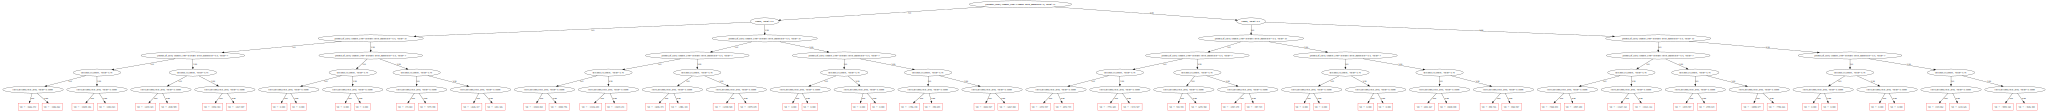

In [185]:
tree

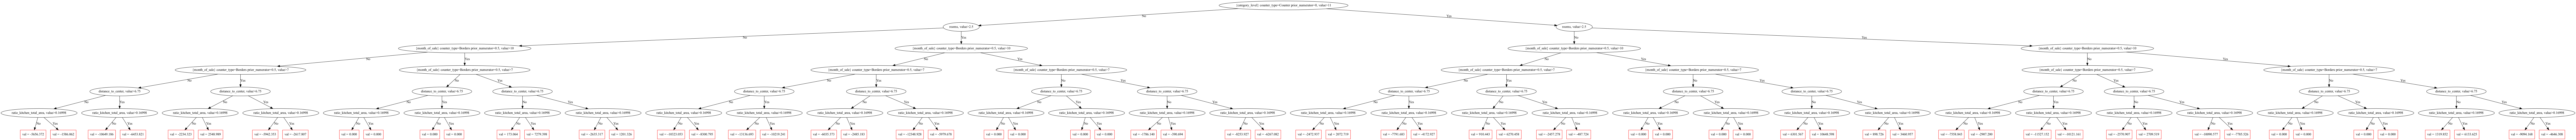

In [186]:
import IPython
IPython.display.display_png(tree)